In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [9]:
df_bin_MS=pd.read_pickle('df_ruth.pkl')
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
df_bin_MS=pd.merge(df_isoages,df_bin_MS,left_on='KIC',right_on='KID',how='inner')
print(np.shape(df_bin_MS))

APOGEE=pd.read_pickle('/Users/lucy/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')


# cross-match
df_bin_MS=pd.merge(APOGEE,df_bin_MS,left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')

df_bin_MS=df_bin_MS.loc[df_bin_MS['FE_H']>-5000]

print(np.shape(df_bin_MS))

(30127, 252)
(391, 454)


In [10]:
list(df_bin_MS.columns)

['APSTAR_ID',
 'TARGET_ID',
 'ASPCAP_ID',
 'FILE',
 'APOGEE_ID',
 'TELESCOPE',
 'LOCATION_ID',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA_x',
 'DEC',
 'GLON',
 'GLAT',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE_TARGET3',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'COMBTYPE',
 'COMMISS',
 'SNR',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'VERR_MED',
 'OBSVHELIO_AVG',
 'OBSVSCATTER',
 'OBSVERR',
 'OBSVERR_MED',
 'SYNTHVHELIO_AVG',
 'SYNTHVSCATTER',
 'SYNTHVERR',
 'SYNTHVERR_MED',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'SYNTHSCATTER',
 'MEANFIB',
 'SIGFIB',
 'SNREV',
 'APSTAR_VERSION',
 'ASPCAP_VERSION',
 'RESULTS_VERSION',
 'EXTRATARG',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'TEFF',
 'TEFF_ERR',
 'LOGG',
 'LOGG_ERR',
 'VMICRO',
 'VMACRO',
 'VSINI',
 'M_H',
 'M_H_ERR',
 'ALPHA_M',
 'ALPHA_M_ERR

In [11]:
cols=[i for i in APOGEE.columns if '_FE' in i]
cols=[i for i in cols if '_FEH' not in i]
cols=[i for i in cols if '_ERR' not in i]
cols=[i for i in cols if '_FLAG' not in i]

abund=['C_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','SC_FE','TI_FE',
      'V_FE','CR_FE','MN_FE','CO_FE','NI_FE','CU_FE','ZN_FE','SR_FE','Y_FE','ZR_FE',
      'BA_FE','LA_FE','CE_FE','PR_FE','ND_FE','SM_FE','EU_FE','GD_FE','DY_FE']

-0.003638490103185177


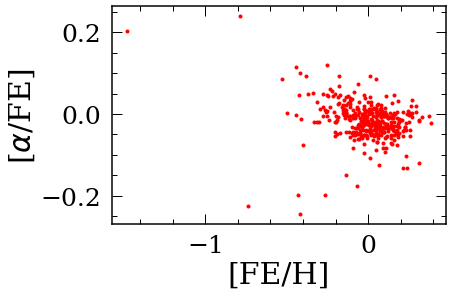

In [12]:
# alpha/Fe
plt.plot(figsize=(10,8))
plt.plot(df_bin_MS['FE_H'],df_bin_MS['ALPHA_M'],'r.')
plt.ylabel('[$\\alpha$/FE]')
plt.xlabel('[FE/H]')
print(np.mean(df_bin_MS['FE_H']))


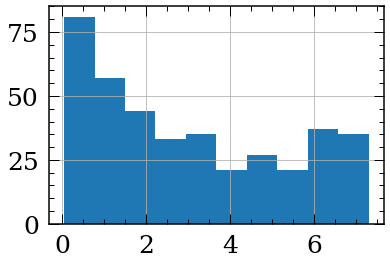

In [13]:
df_bin_MS['iso_age_err1'].hist()

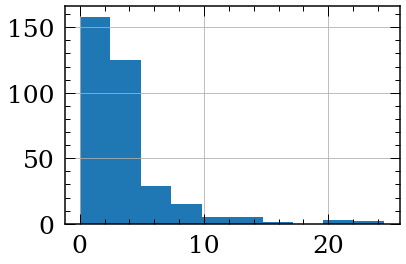

In [14]:
df_bin_MS['kin_age'].hist()

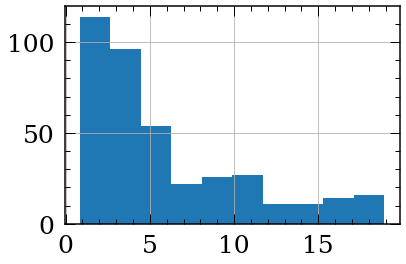

In [15]:
df_bin_MS['iso_age'].hist()

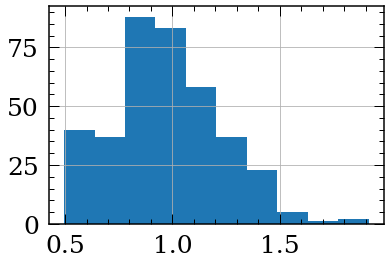

In [17]:
df_bin_MS=df_bin_MS.loc[abs(df_bin_MS['Mass']-1)<0.5]

df_bin_MS['mass'].hist()

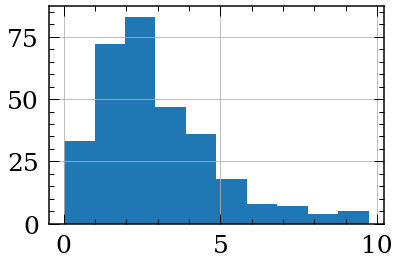

In [31]:
df_bin_MS=df_bin_MS.loc[abs(df_bin_MS['kin_age'])<10]

df_bin_MS['kin_age'].hist()

# put into age bins

In [18]:
def rowdow(df,window,window_var,med_var):
    minsize=min(df[window_var].values)
    maxsize=max(df[window_var].values)
    
    rollsize=int(np.ceil(float(maxsize-minsize)/float(window)))
    
    window_var_a=df[[window_var]].values
    med_var_a=df[[med_var]].values
    
    med_wind=np.zeros(rollsize)
    med_var=np.zeros(rollsize)
    
    for i in range(rollsize):
        mask=(window_var_a>=minsize+window*i)&(window_var_a<=minsize+window*(i+1))

        med_wind[i]=minsize+window*(i+0.5)
        med_var[i]=np.median(med_var_a[mask])
        
    return med_wind,med_var

# plot against Logg

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

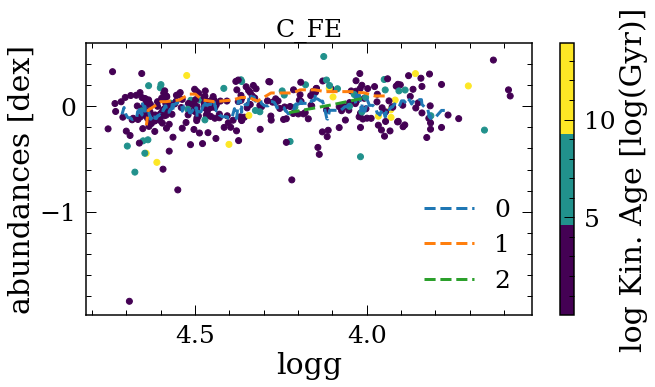

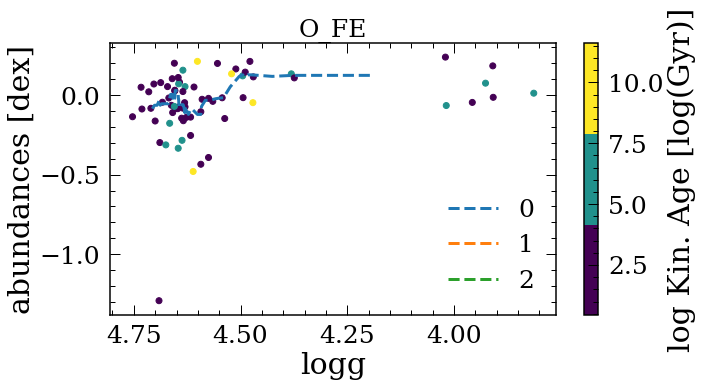

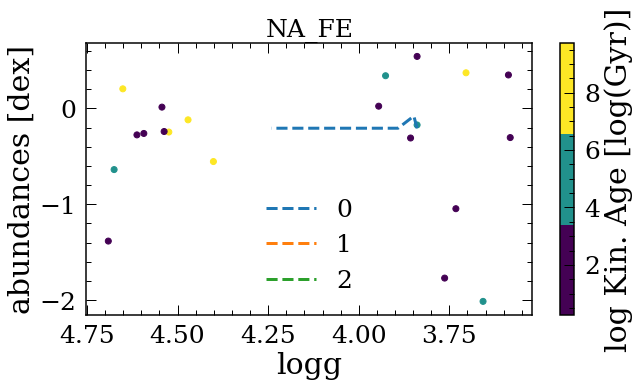

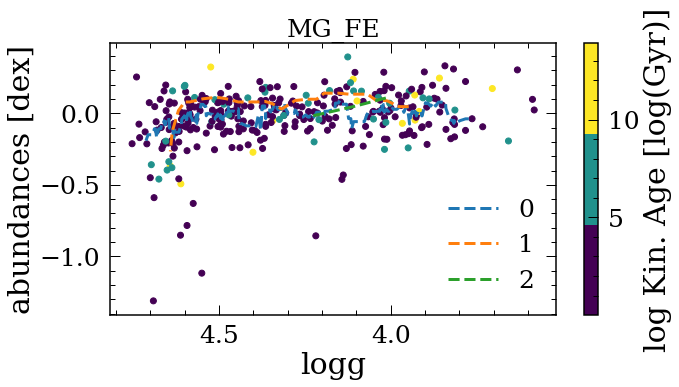

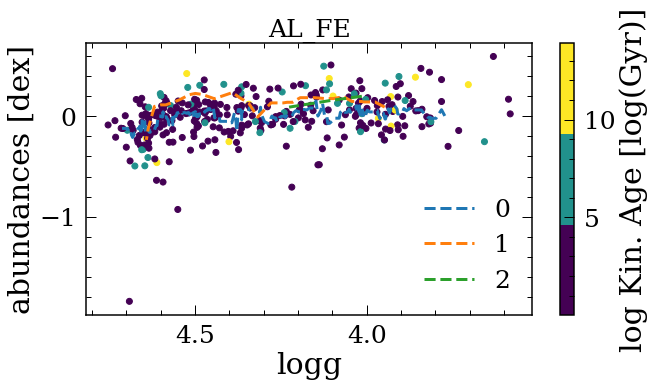

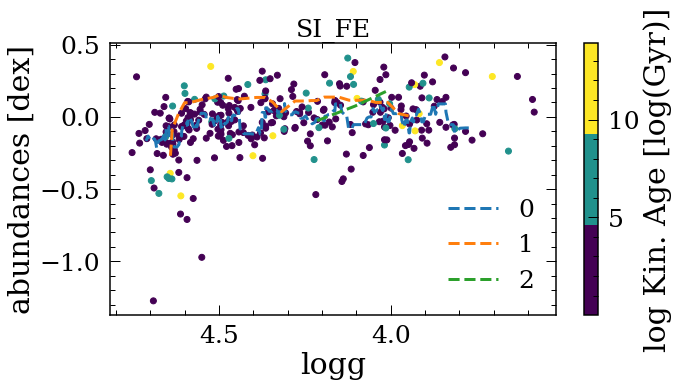

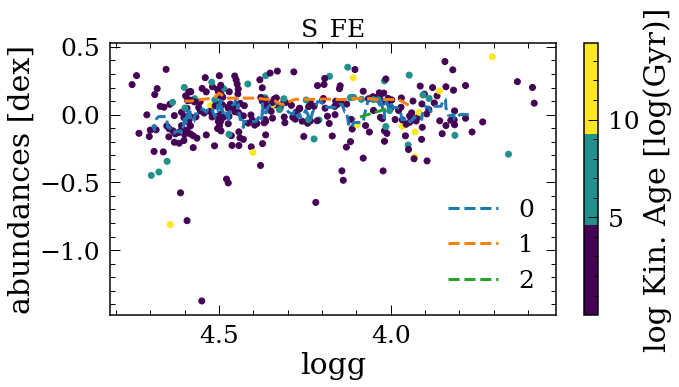

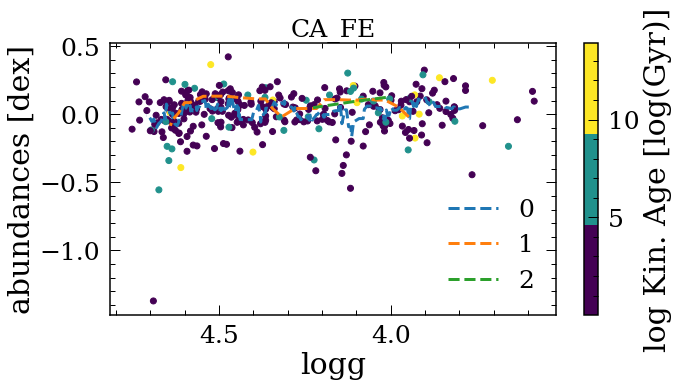

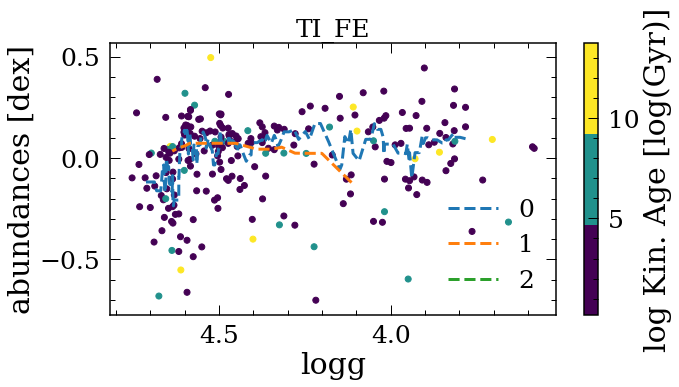

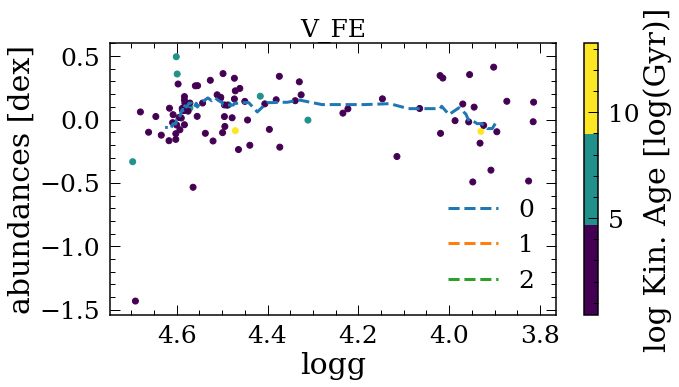

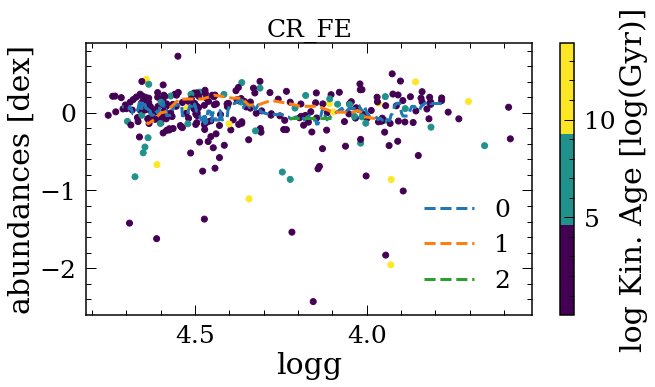

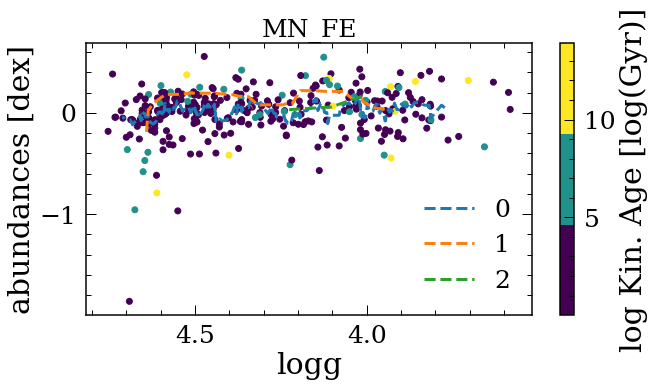

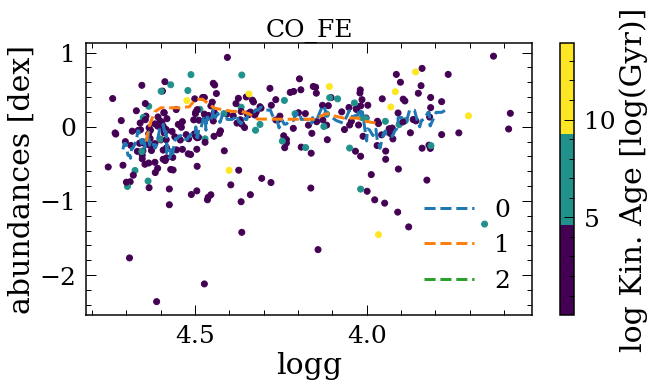

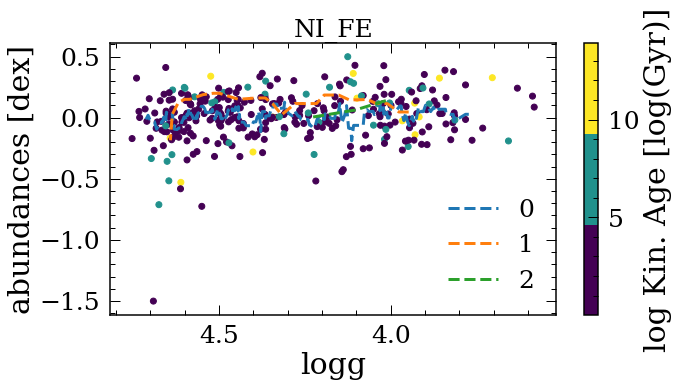

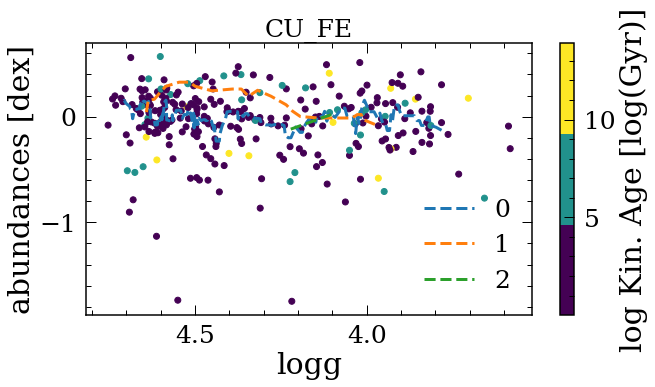

In [23]:
bins=3.
binsize=(max(df_bin_MS['kin_age'])-min(df_bin_MS['kin_age']))/bins

cm = plt.cm.get_cmap('viridis',3)
for bunds in abund:
    if bunds in df_bin_MS.columns:
        df_plt=df_bin_MS.loc[abs(df_bin_MS[bunds])<100]
        if len(df_plt)>10:
            df_plt[bunds]=df_plt[bunds]+df_plt['FE_H']
            plt.figure(figsize=(10,5))
            plt.scatter(df_plt['logg'],df_plt[bunds],c=df_plt['kin_age'],cmap=cm,edgecolors=None)
            for i in range(int(bins)):
                mask=(df_plt['kin_age']>min(df_bin_MS['kin_age'])+(i)*binsize) & (df_plt['kin_age']<min(df_bin_MS['kin_age'])+(i+1)*binsize)
                if sum(mask)==0:
                    continue
                else:
                    df_plt_logg=df_plt.loc[mask].sort_values(by=['logg'])
                    
                    plt.plot(df_plt_logg['logg'].rolling(10).median(),
                             df_plt_logg[bunds].rolling(10).median(),'--',linewidth=3,label=str(i))
                
            plt.xlabel('logg')
            plt.ylabel('abundances [dex]')
            cb=plt.colorbar()
            cb.set_label('log Kin. Age [log(Gyr)]')
            plt.gca().invert_xaxis()
            plt.title(bunds,fontsize=25)
            plt.legend()
   

# plot against Teff

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

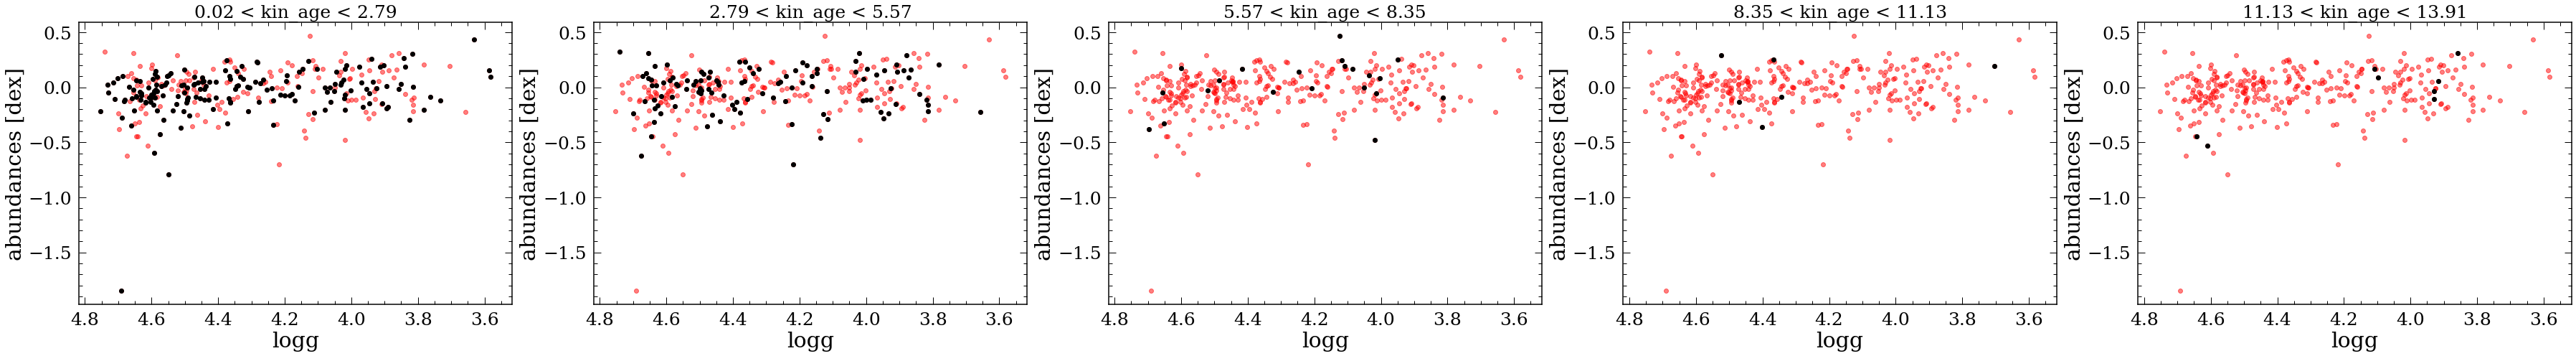

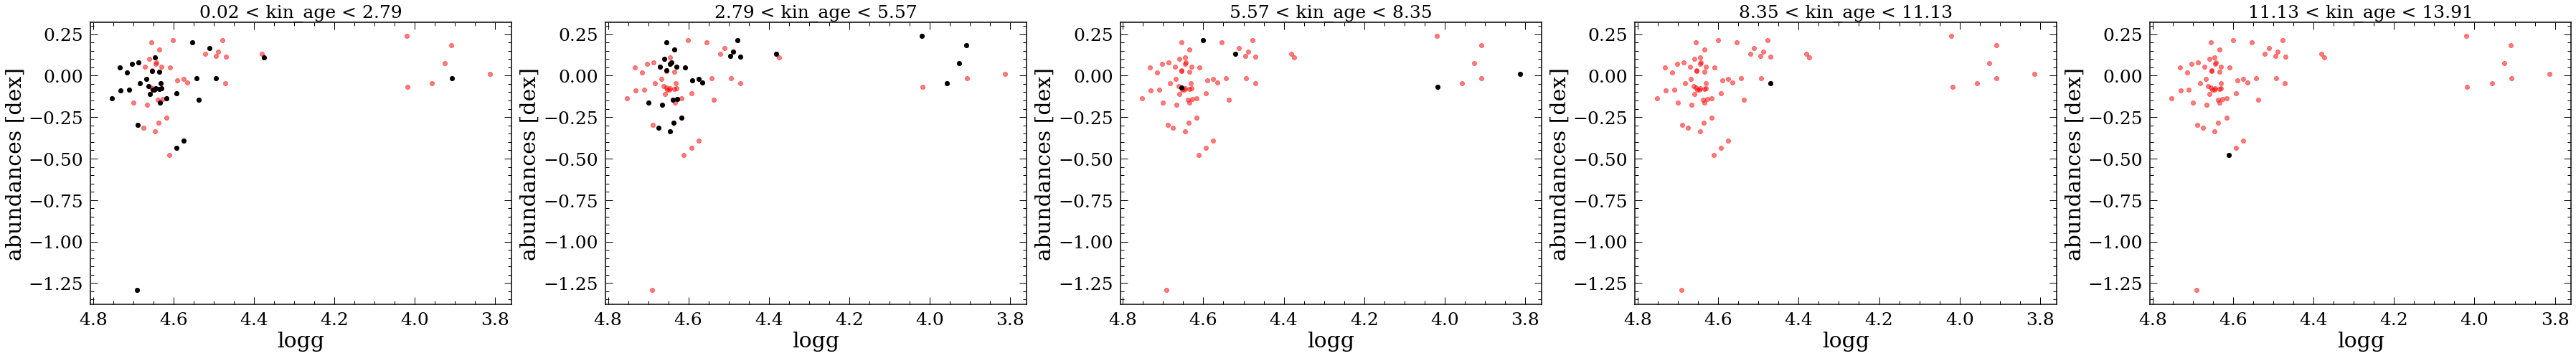

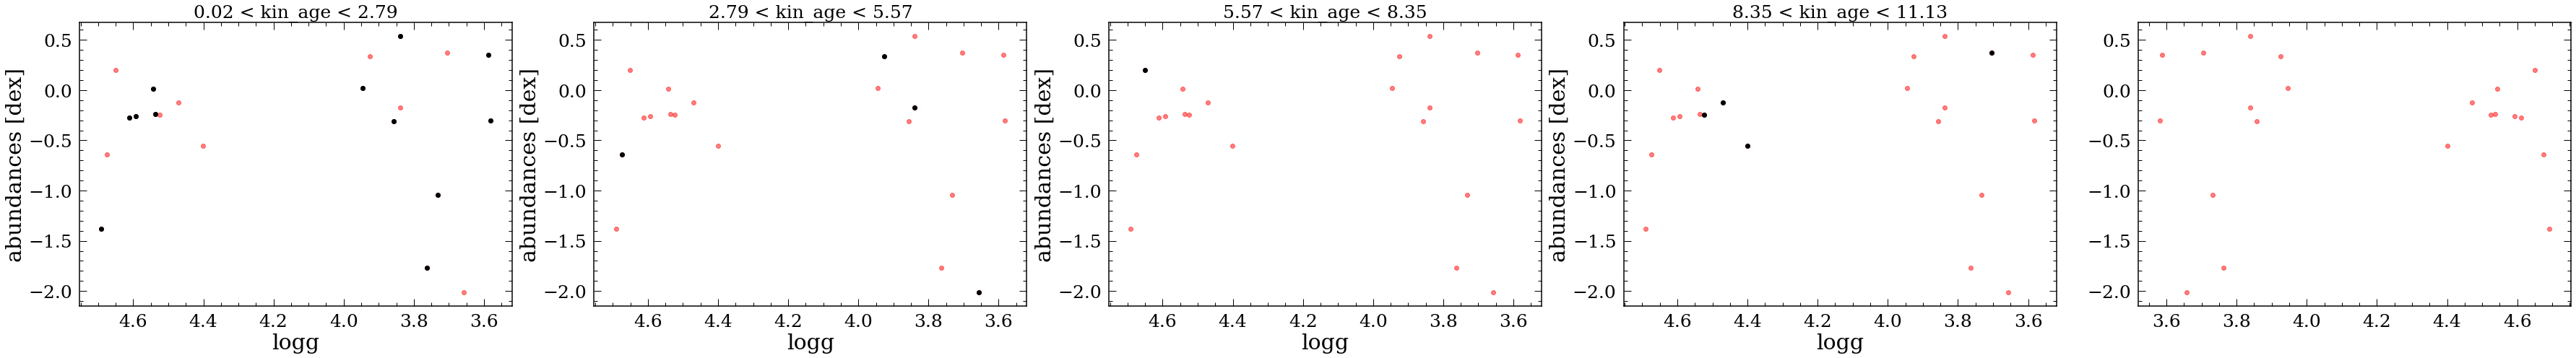

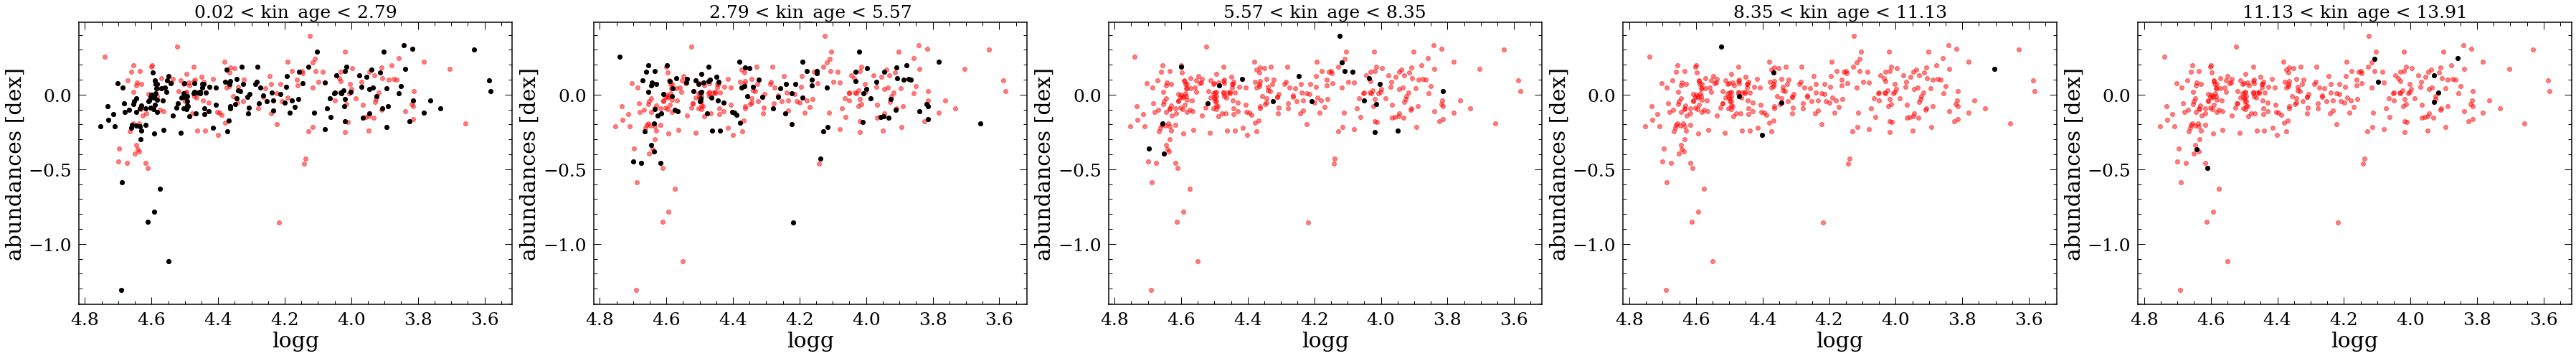

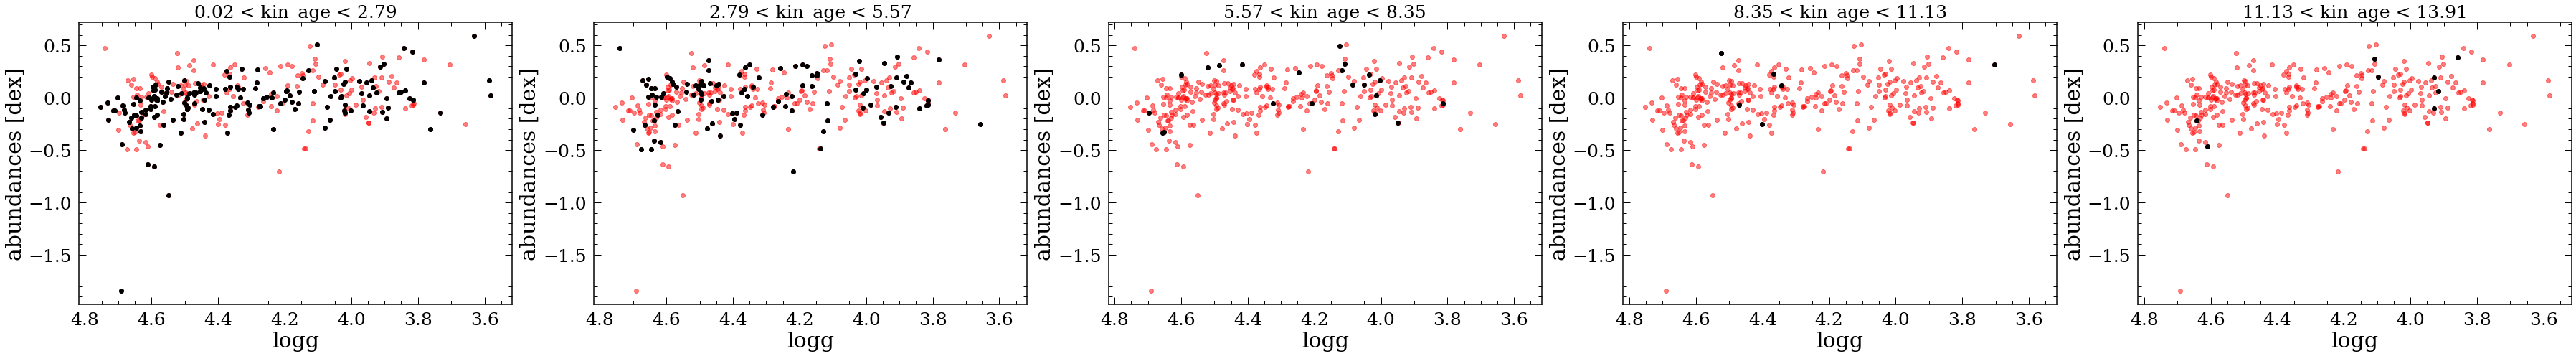

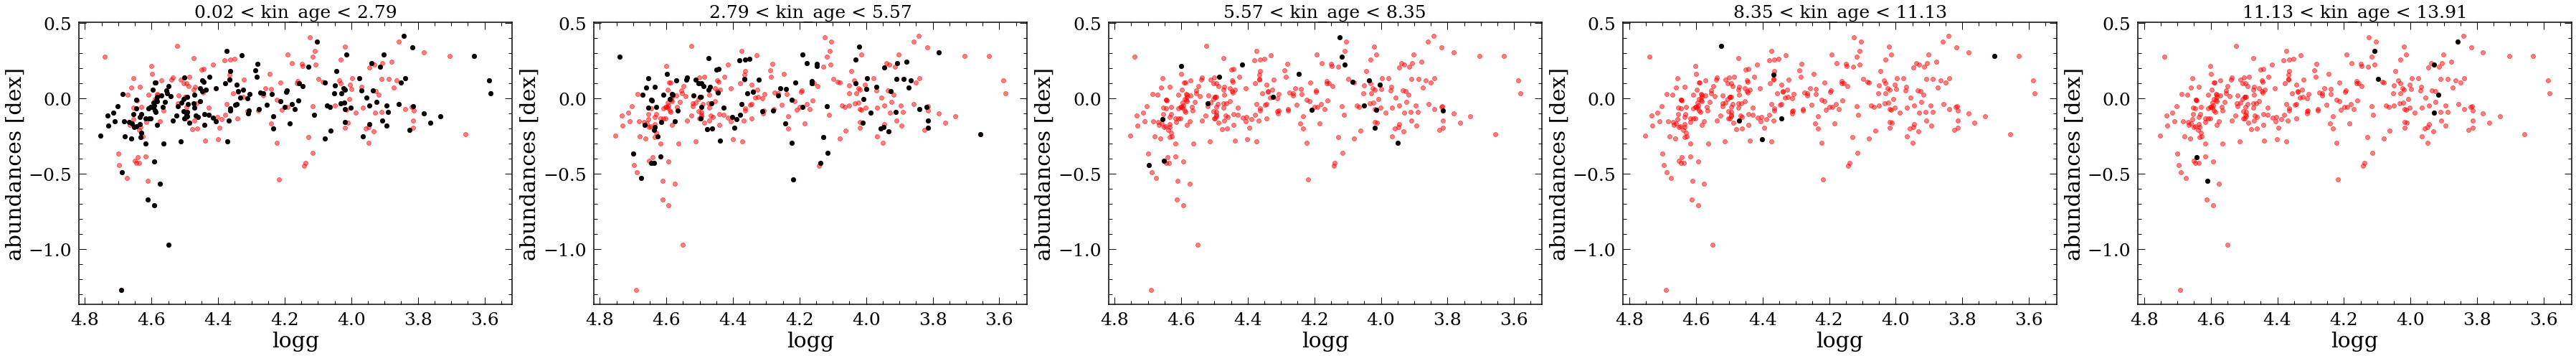

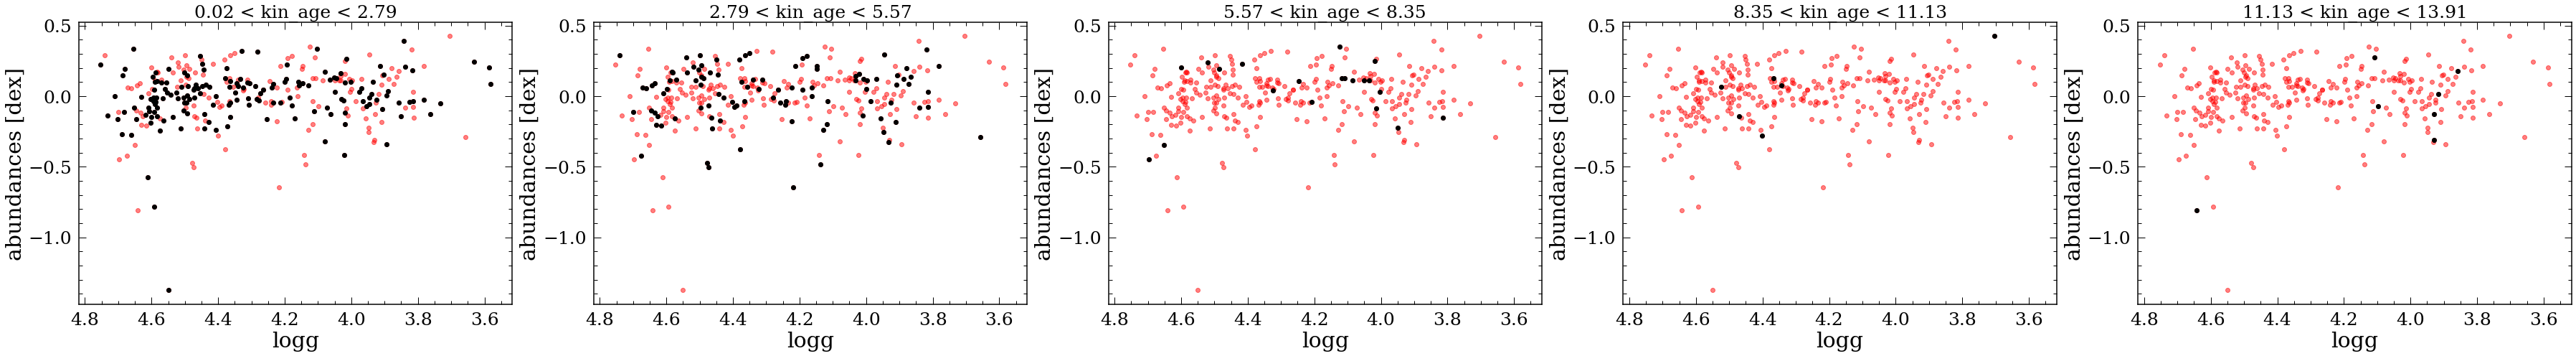

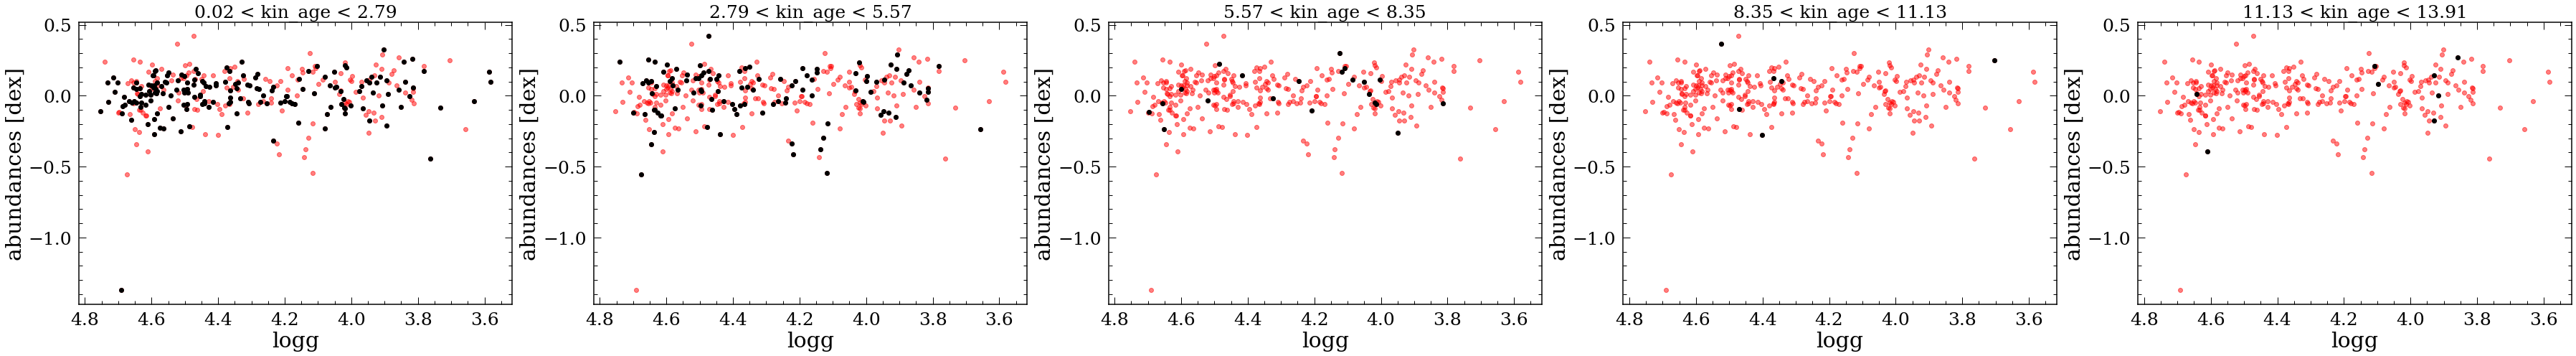

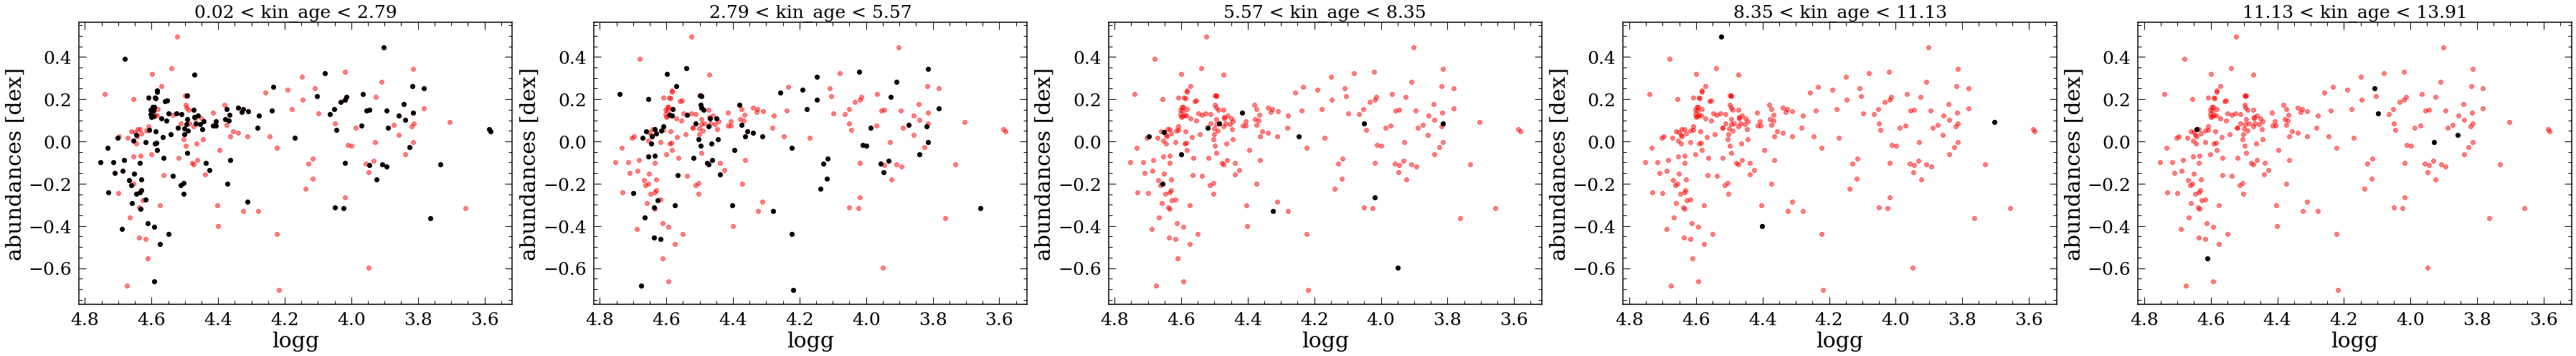

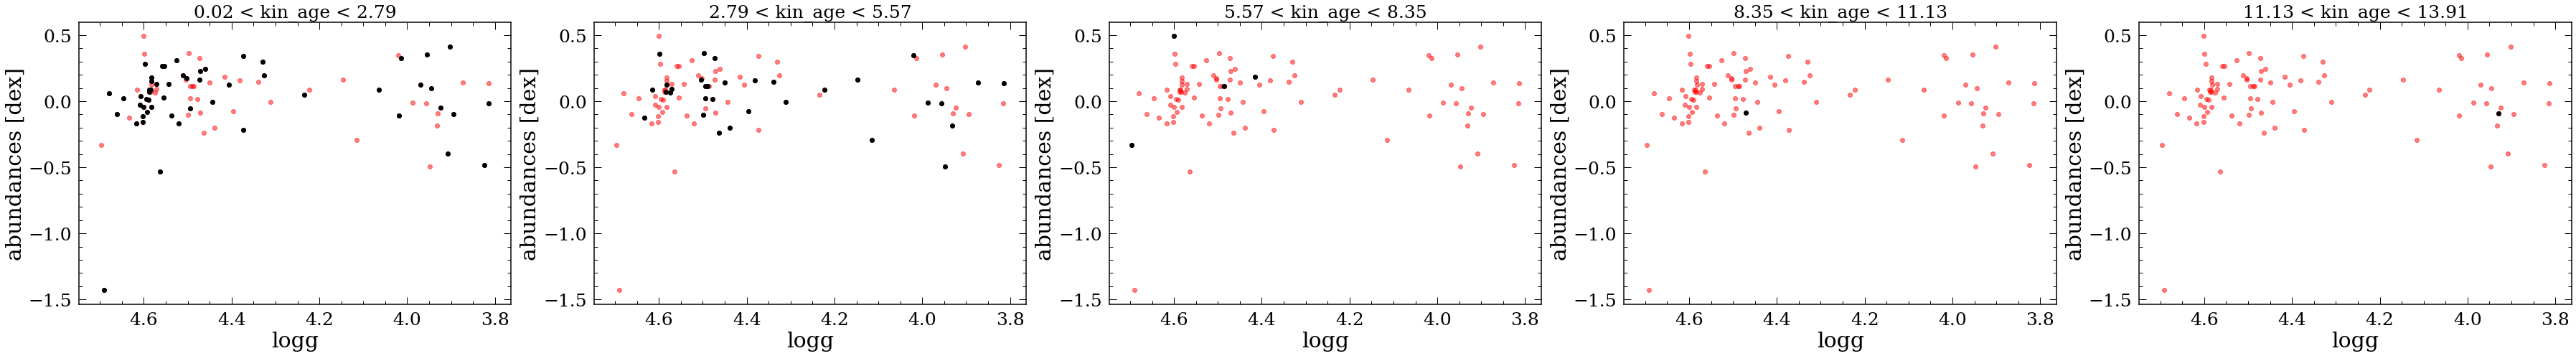

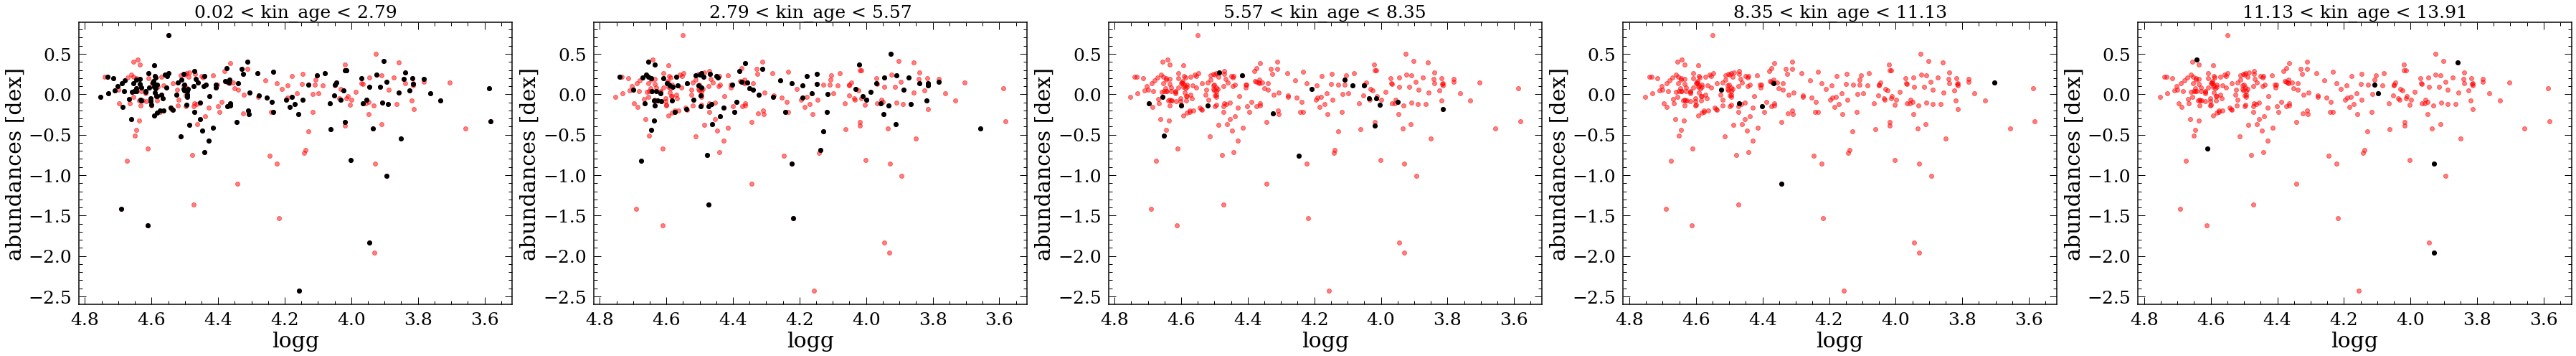

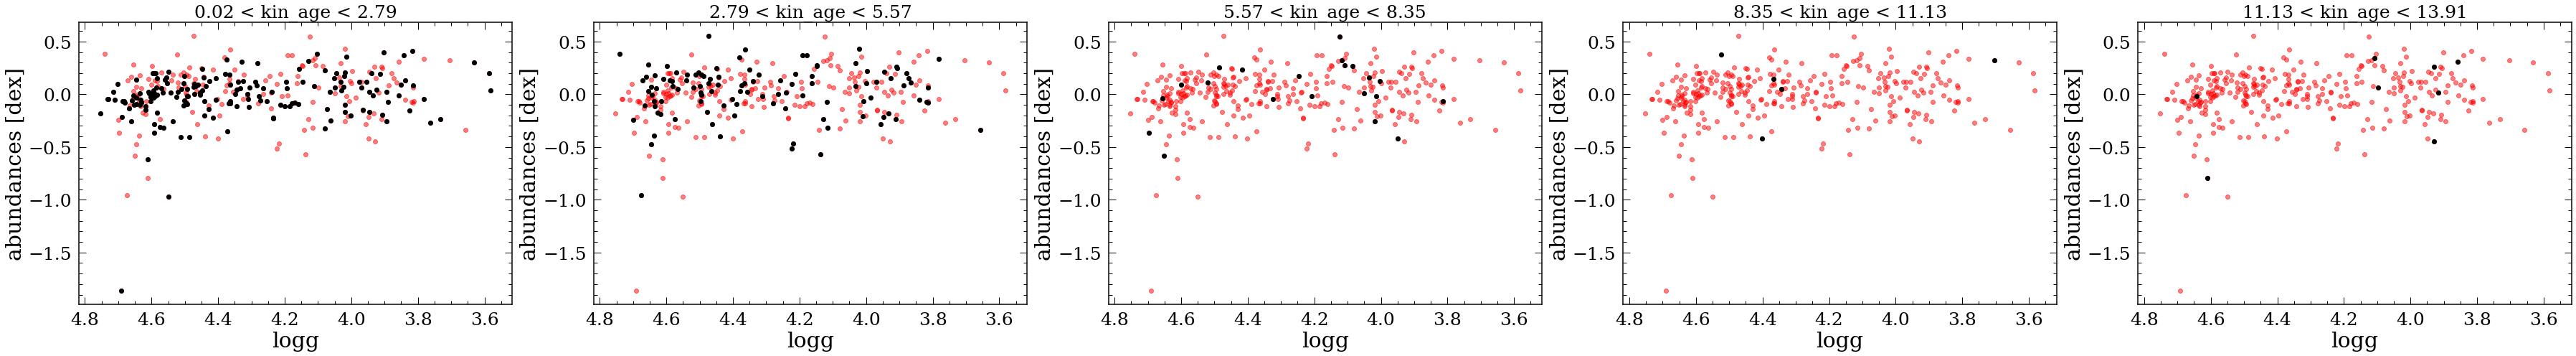

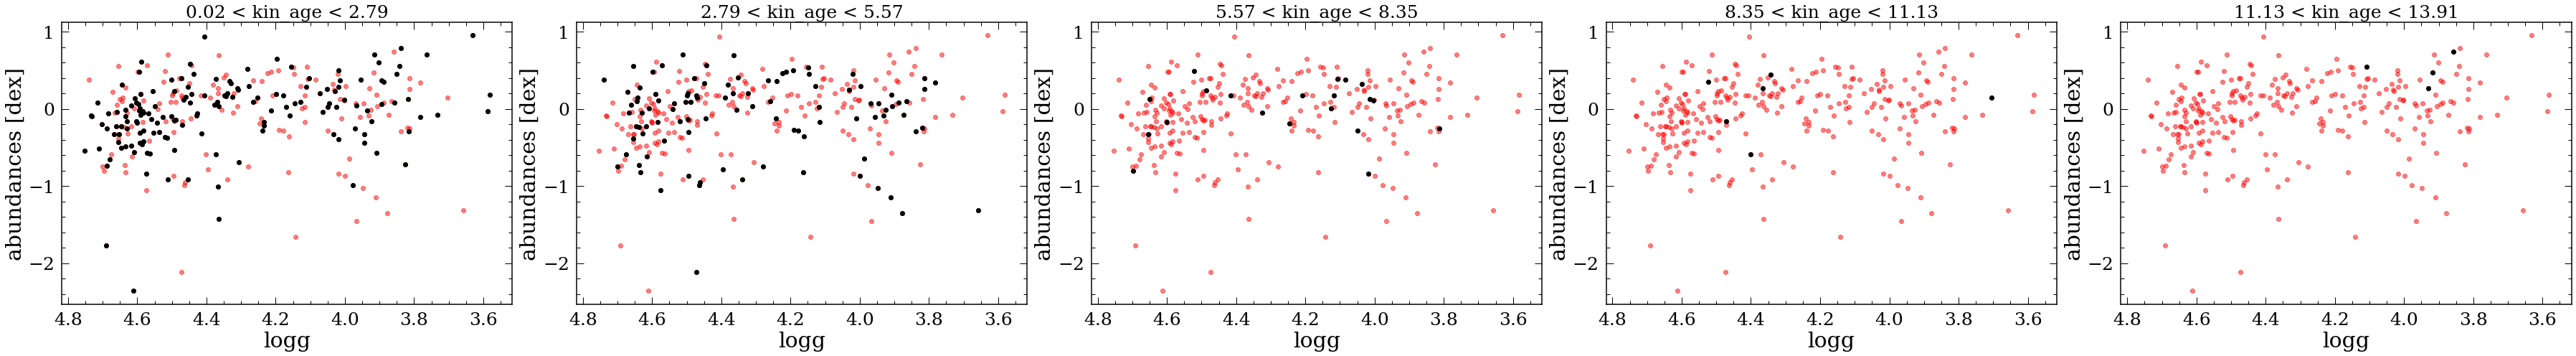

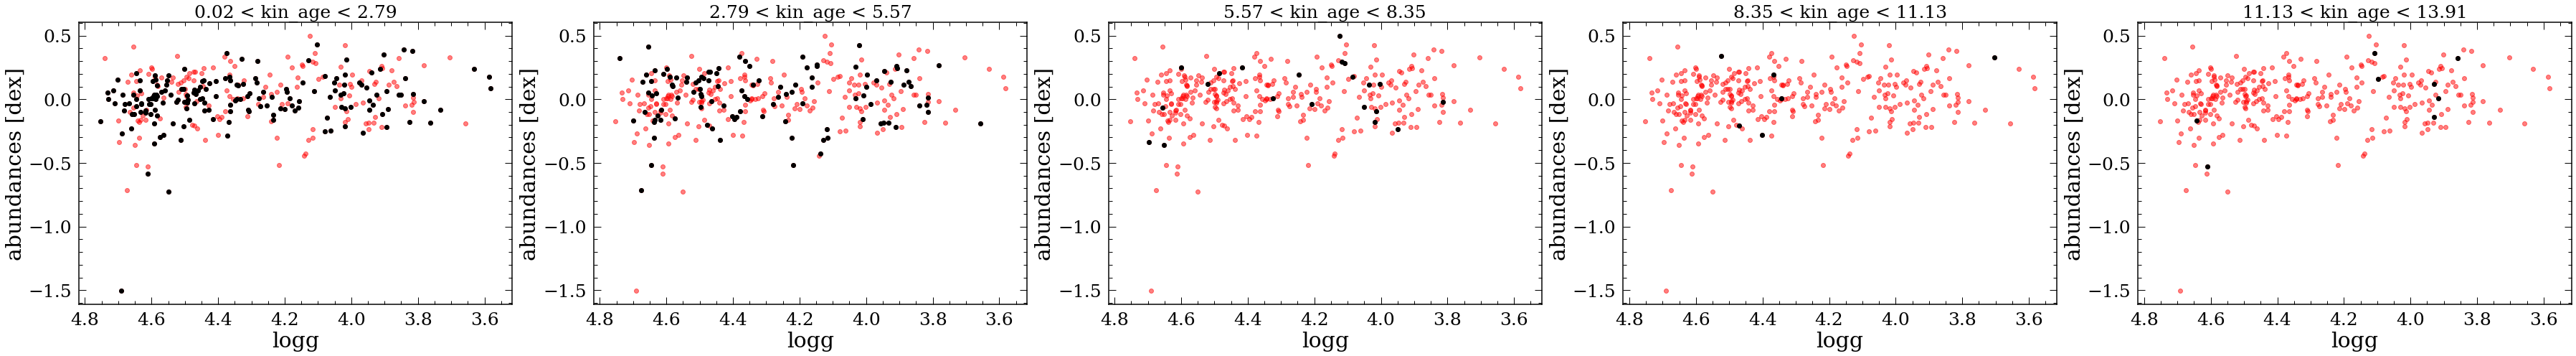

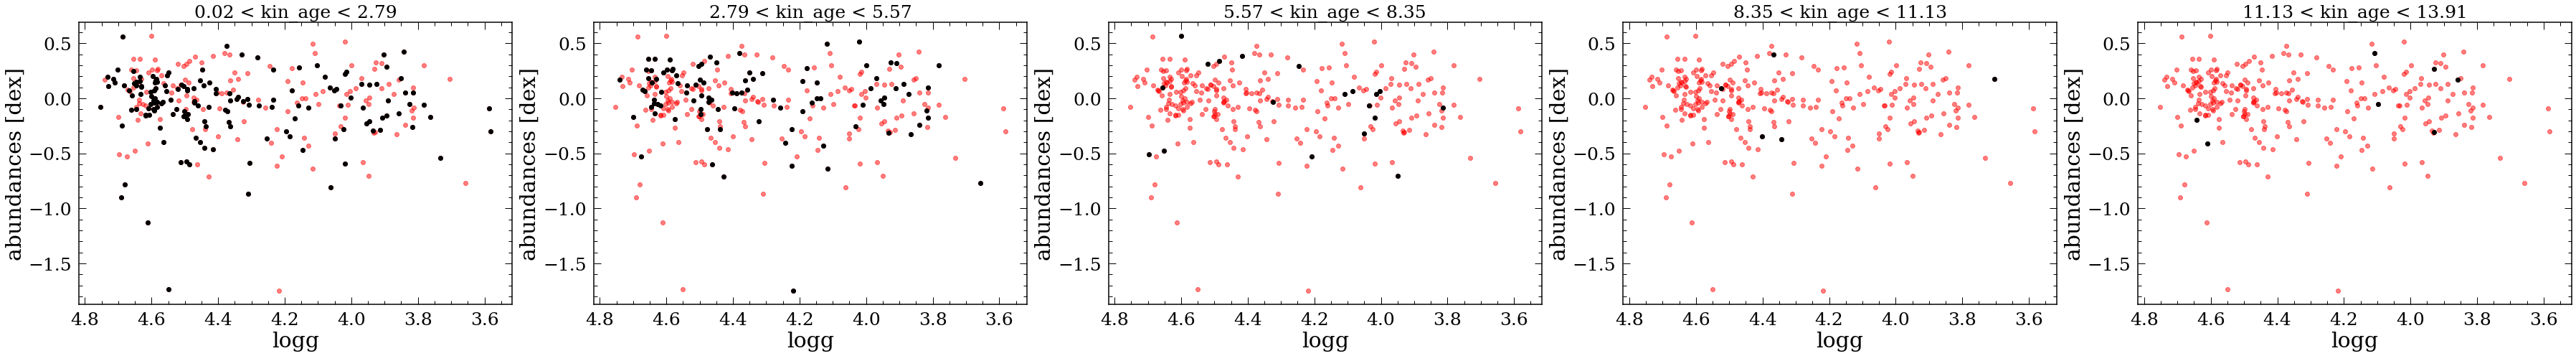

In [25]:
bins=5.
binsize=(max(df_bin_MS['kin_age'])-min(df_bin_MS['kin_age']))/bins

cm = plt.cm.get_cmap('viridis',3)
for bunds in abund:
    if bunds in df_bin_MS.columns:
        df_plt=df_bin_MS.loc[abs(df_bin_MS[bunds])<100]
        if len(df_plt)>10:
            df_plt[bunds]=df_plt[bunds]+df_plt['FE_H']
            plt.figure(figsize=(10*int(bins),7))
            for i in range(int(bins)):
                plt.subplot(1,int(bins),i+1)
                plt.scatter(df_plt['logg'],df_plt[bunds],c='r',edgecolors=None,alpha=0.5)
                mask=(df_plt['kin_age']>min(df_bin_MS['kin_age'])+(i)*binsize) & (df_plt['kin_age']<min(df_bin_MS['kin_age'])+(i+1)*binsize)
                if sum(mask)==0:
                    continue
                else:
                    df_plt_logg=df_plt.loc[mask].sort_values(by=['logg'])
                    plt.plot(df_plt_logg['logg'],df_plt_logg[bunds],'ko')
                    """
                    plt.plot(df_plt_logg['LOGG'].rolling(10).median(),
                             df_plt_logg[bunds].rolling(10).median(),'--',linewidth=3)
                    """
                    plt.xlabel('logg')
                    plt.ylabel('abundances [dex]')

                    plt.gca().invert_xaxis()
                    plt.title('%.2f < kin_age < %.2f'%(min(df_bin_MS['kin_age'])+(i)*
                                                       binsize,min(df_bin_MS['kin_age'])+
                                                       (i+1)*binsize),fontsize=25)
            plt.tight_layout()
   

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

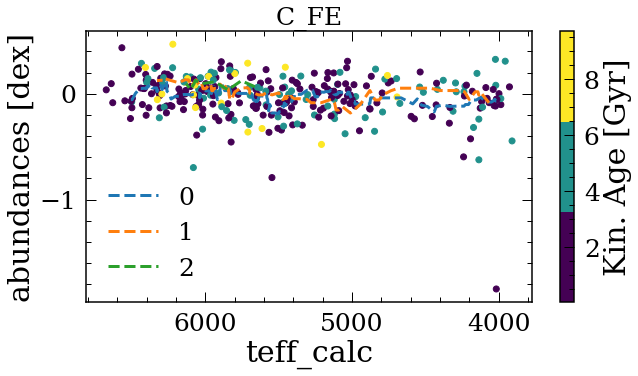

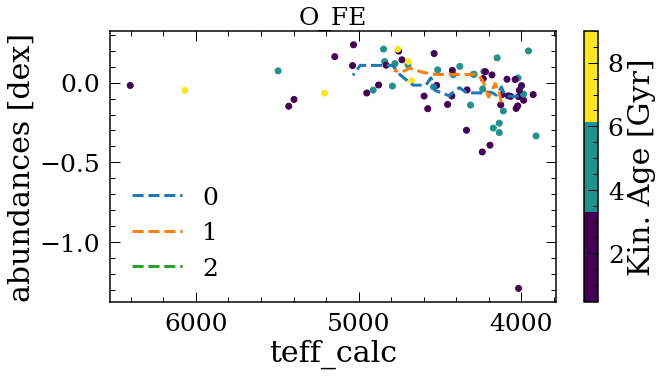

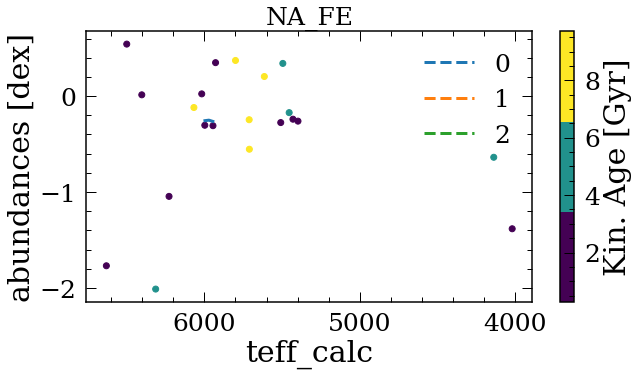

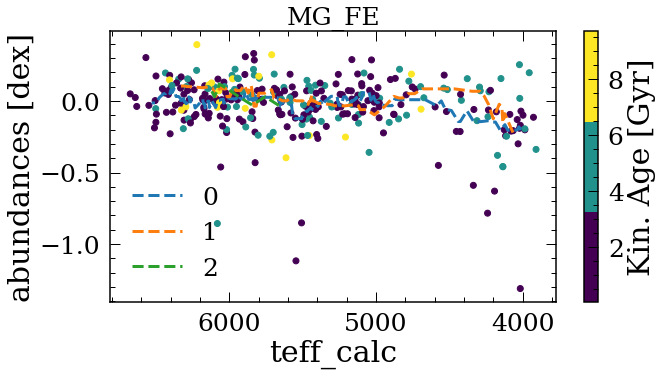

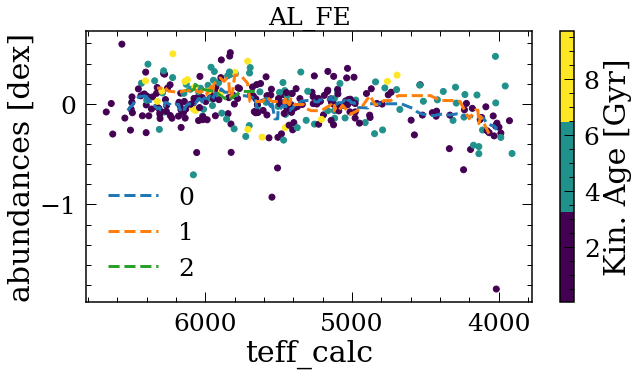

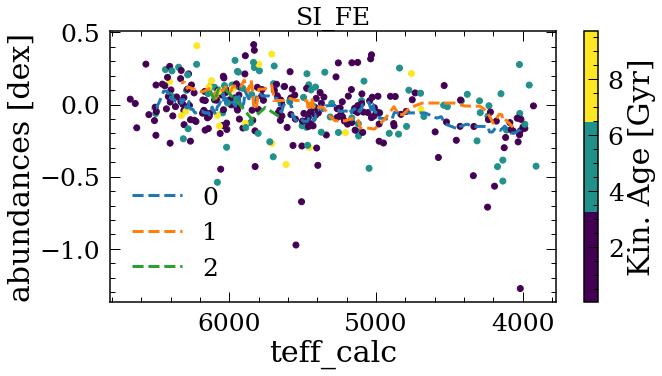

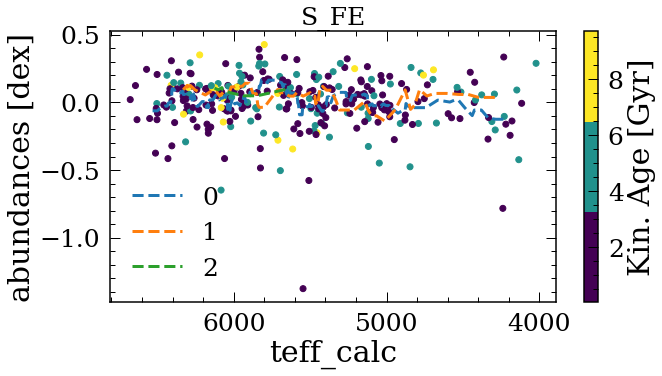

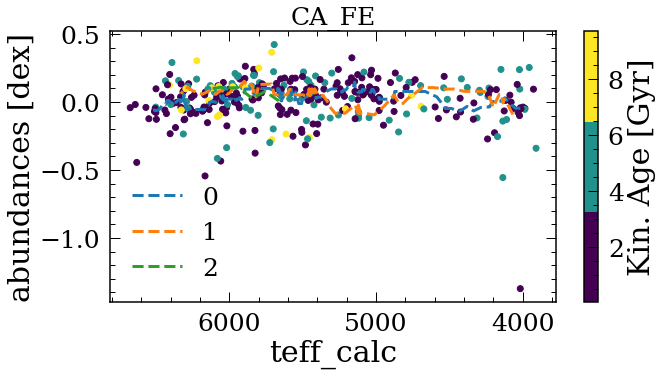

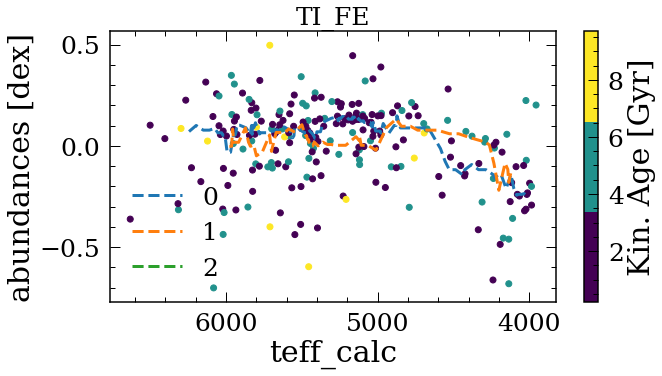

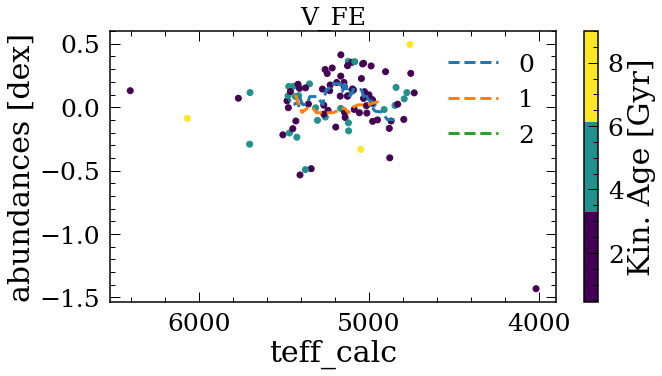

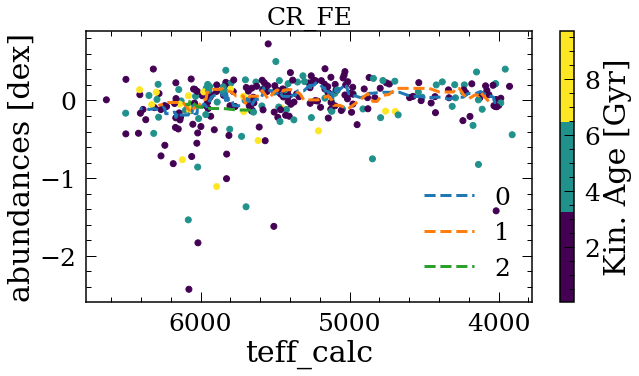

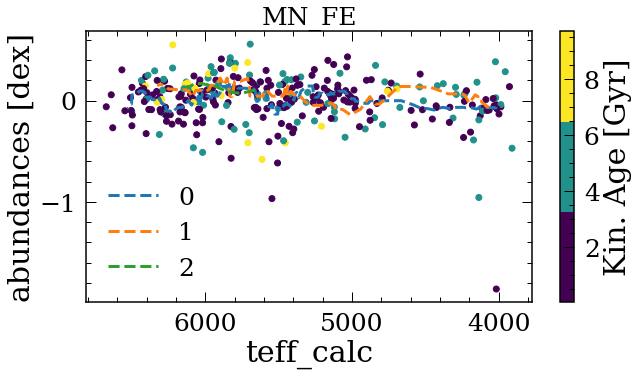

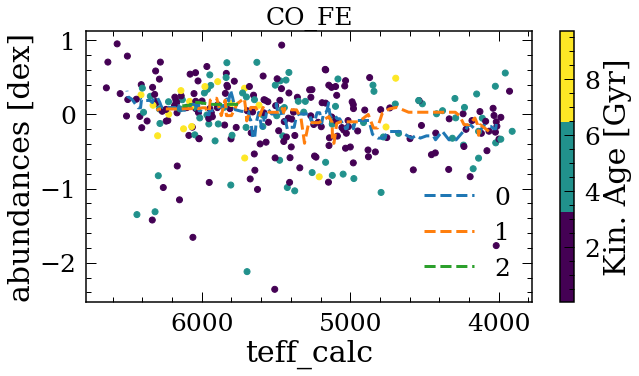

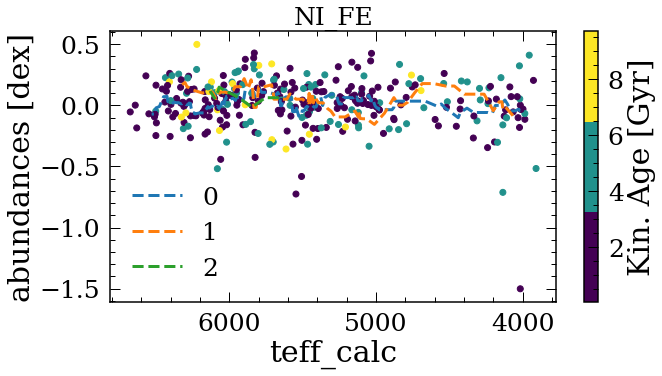

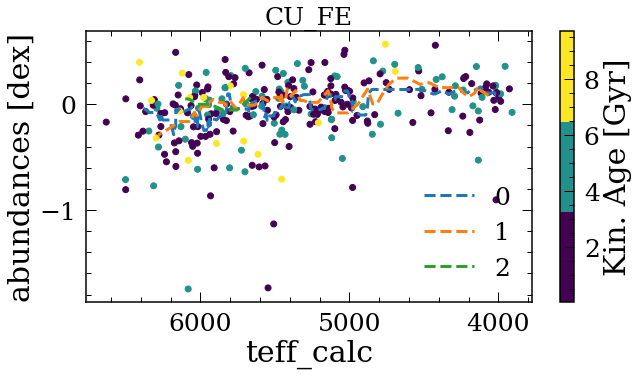

In [32]:
bins=3.
binsize=(max(df_bin_MS['kin_age'])-min(df_bin_MS['kin_age']))/bins

cm = plt.cm.get_cmap('viridis',3)
for bunds in abund:
    if bunds in df_bin_MS.columns:
        df_plt=df_bin_MS.loc[abs(df_bin_MS[bunds])<100]
        if len(df_plt)>10:
            df_plt[bunds]=df_plt[bunds]+df_plt['FE_H']
            plt.figure(figsize=(10,5))
            plt.scatter(df_plt['color_teffs'],df_plt[bunds],c=df_plt['kin_age'],cmap=cm,edgecolors=None)
            for i in range(int(bins)):
                mask=(df_plt['kin_age']>min(df_bin_MS['kin_age'])+(i)*binsize) & (df_plt['kin_age']<min(df_bin_MS['kin_age'])+(i+1)*binsize)
                if sum(mask)==0:
                    continue
                else:
                    df_plt_logg=df_plt.loc[mask].sort_values(by=['color_teffs'])
                    
                    plt.plot(df_plt_logg['color_teffs'].rolling(10).median(),
                             df_plt_logg[bunds].rolling(10).median(),'--',linewidth=3,label=str(i))
                
            plt.xlabel('teff_calc')
            plt.ylabel('abundances [dex]')
            cb=plt.colorbar()
            cb.set_label('Kin. Age [Gyr]')
            plt.gca().invert_xaxis()
            plt.title(bunds,fontsize=25)
            plt.legend()
   

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

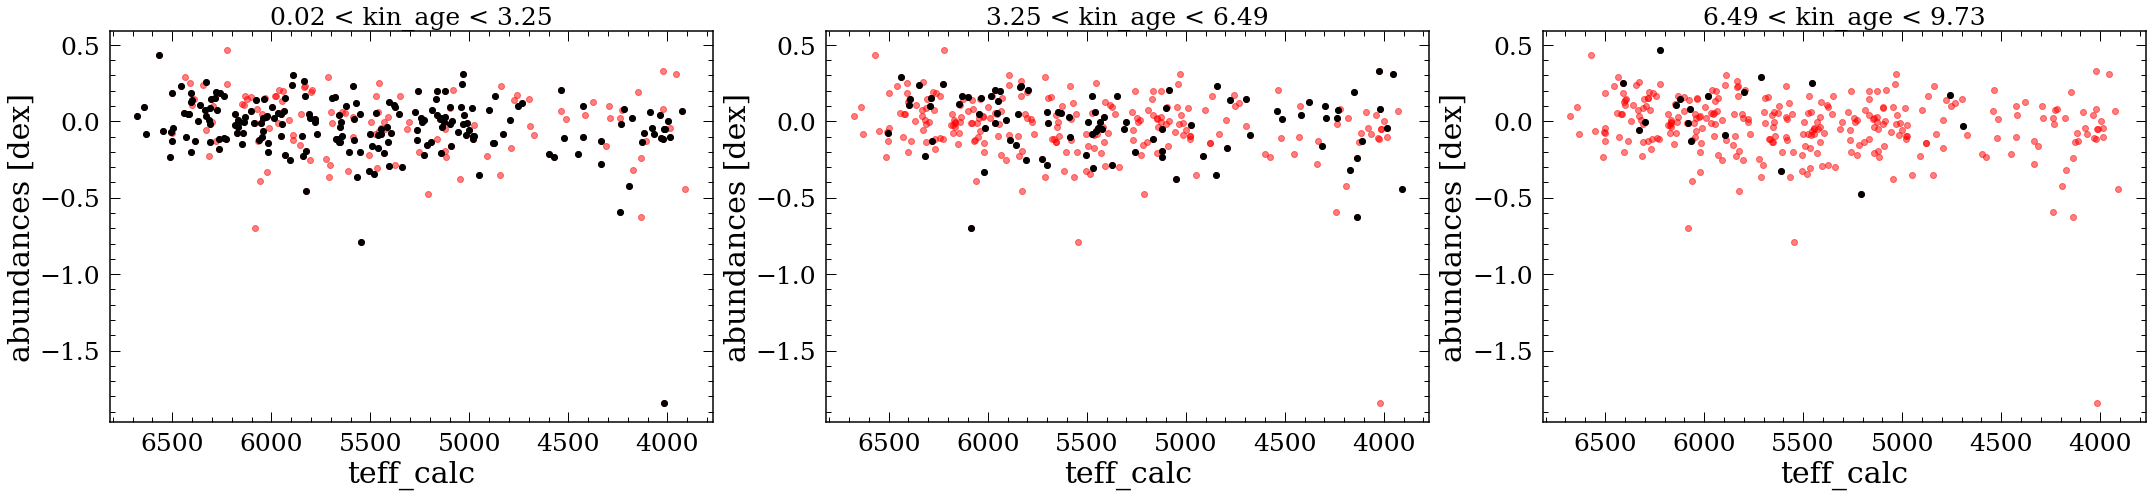

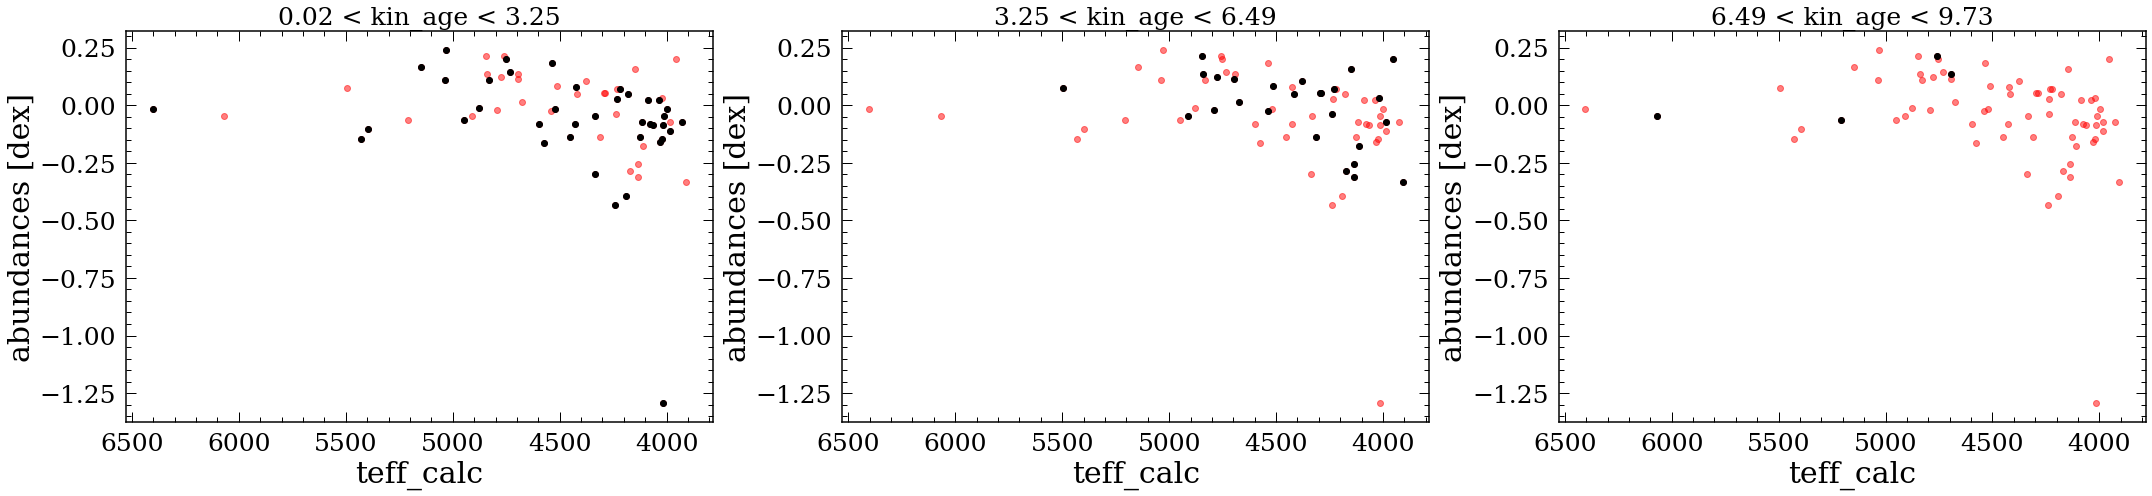

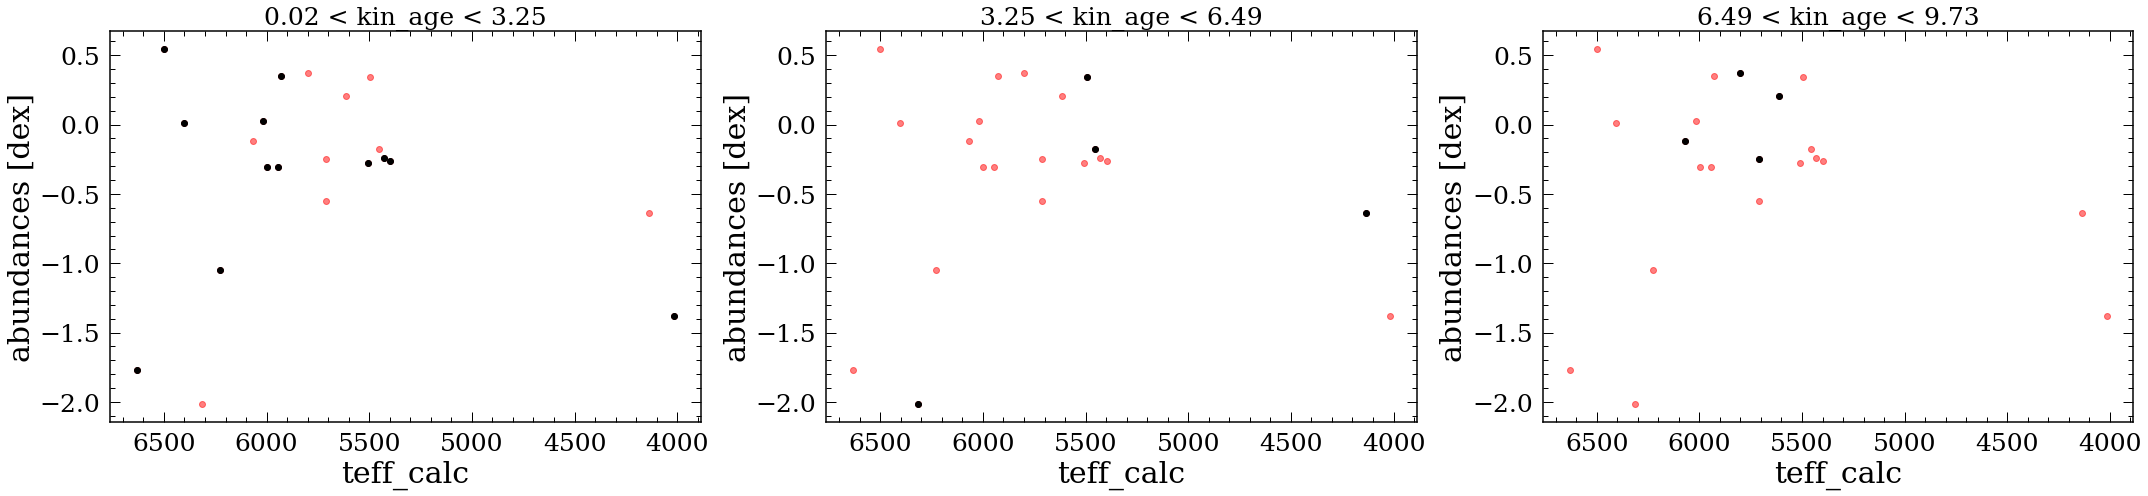

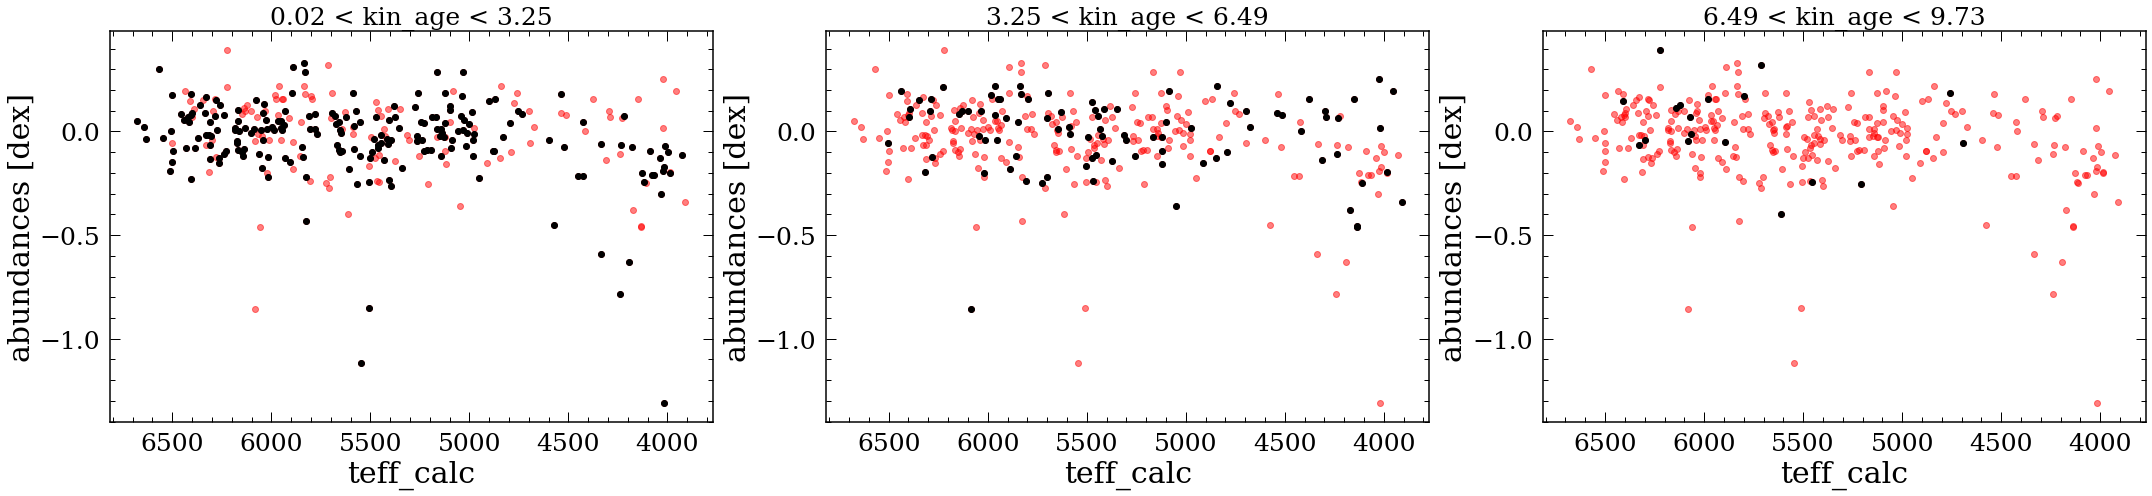

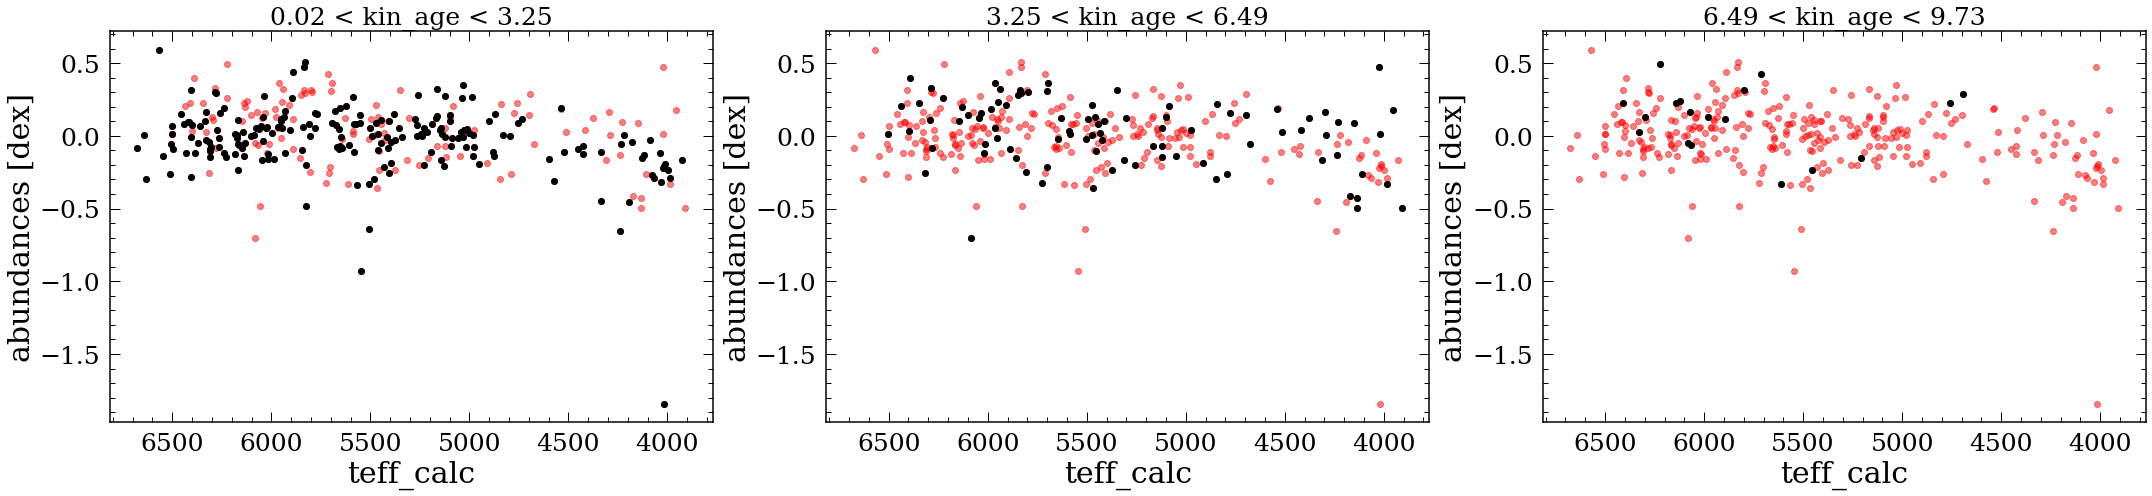

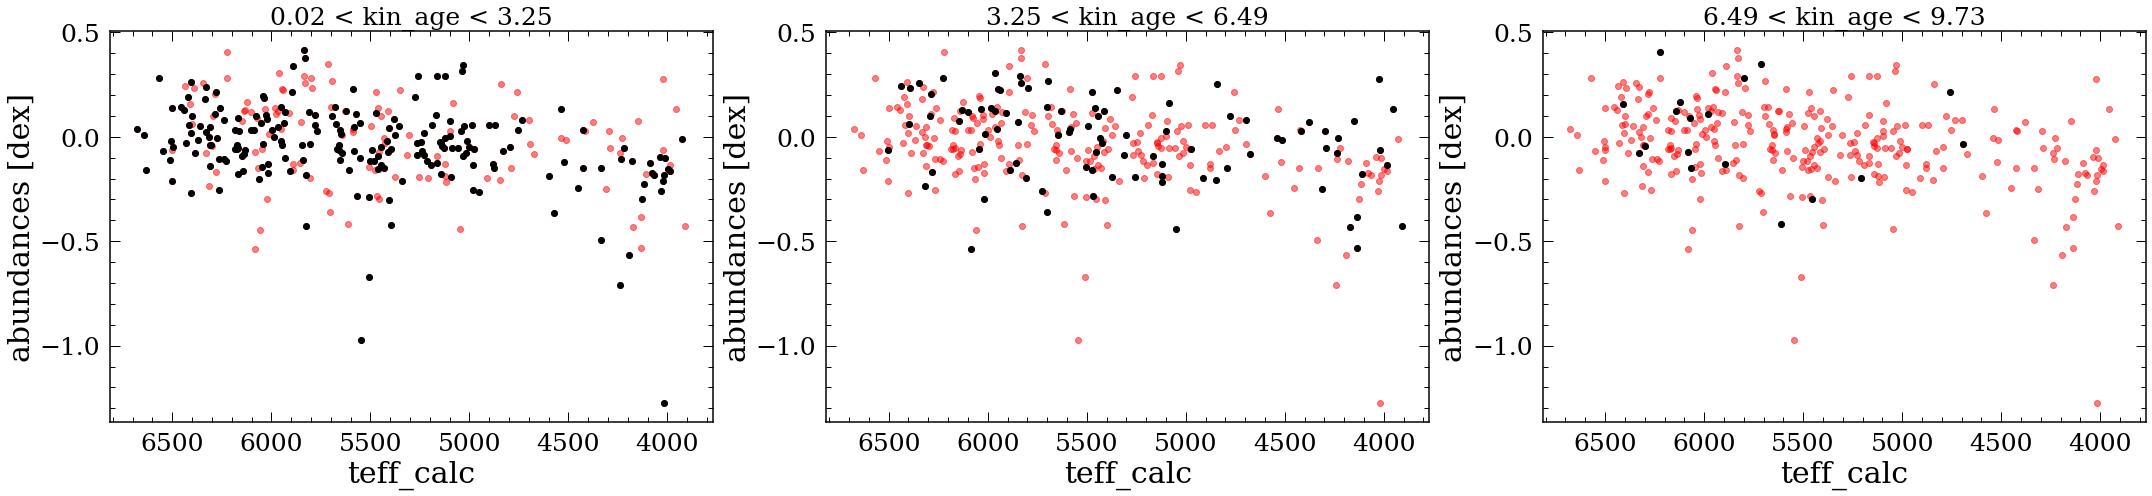

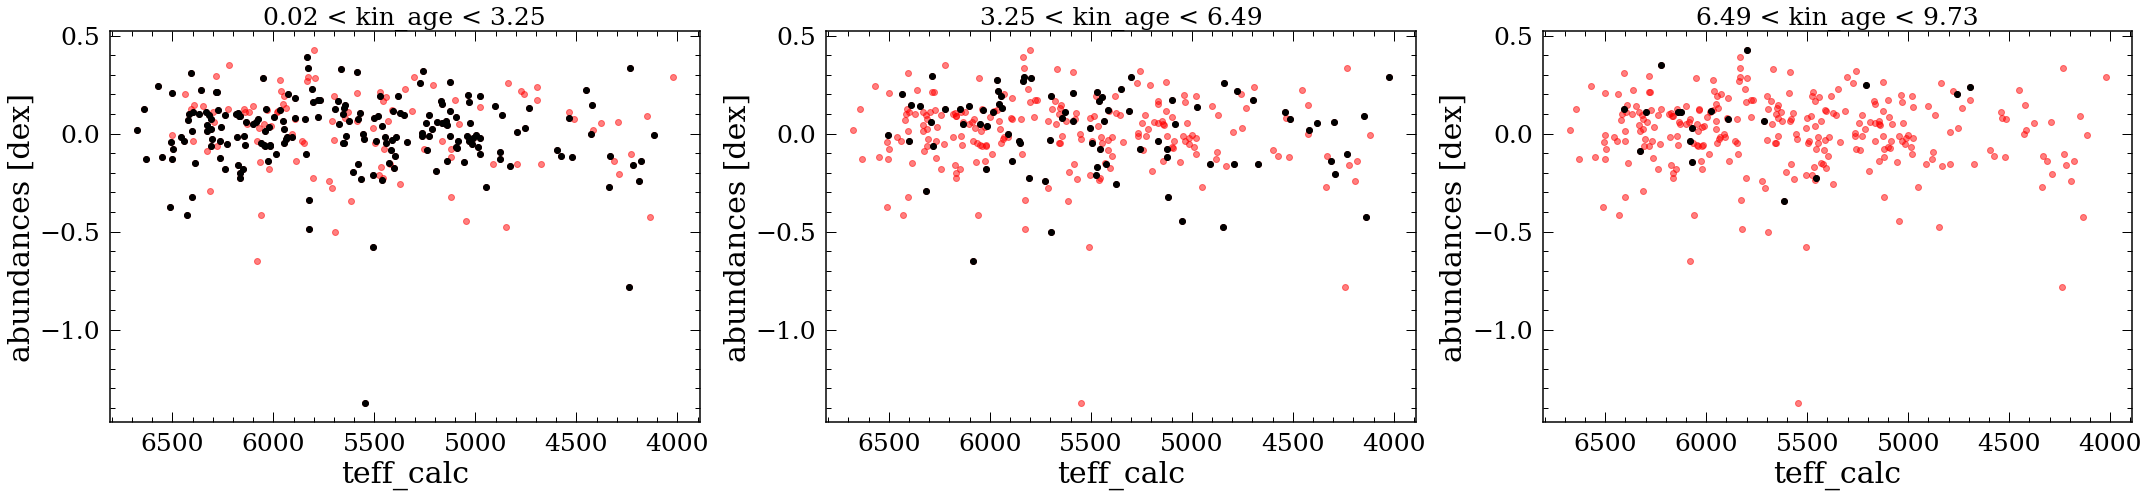

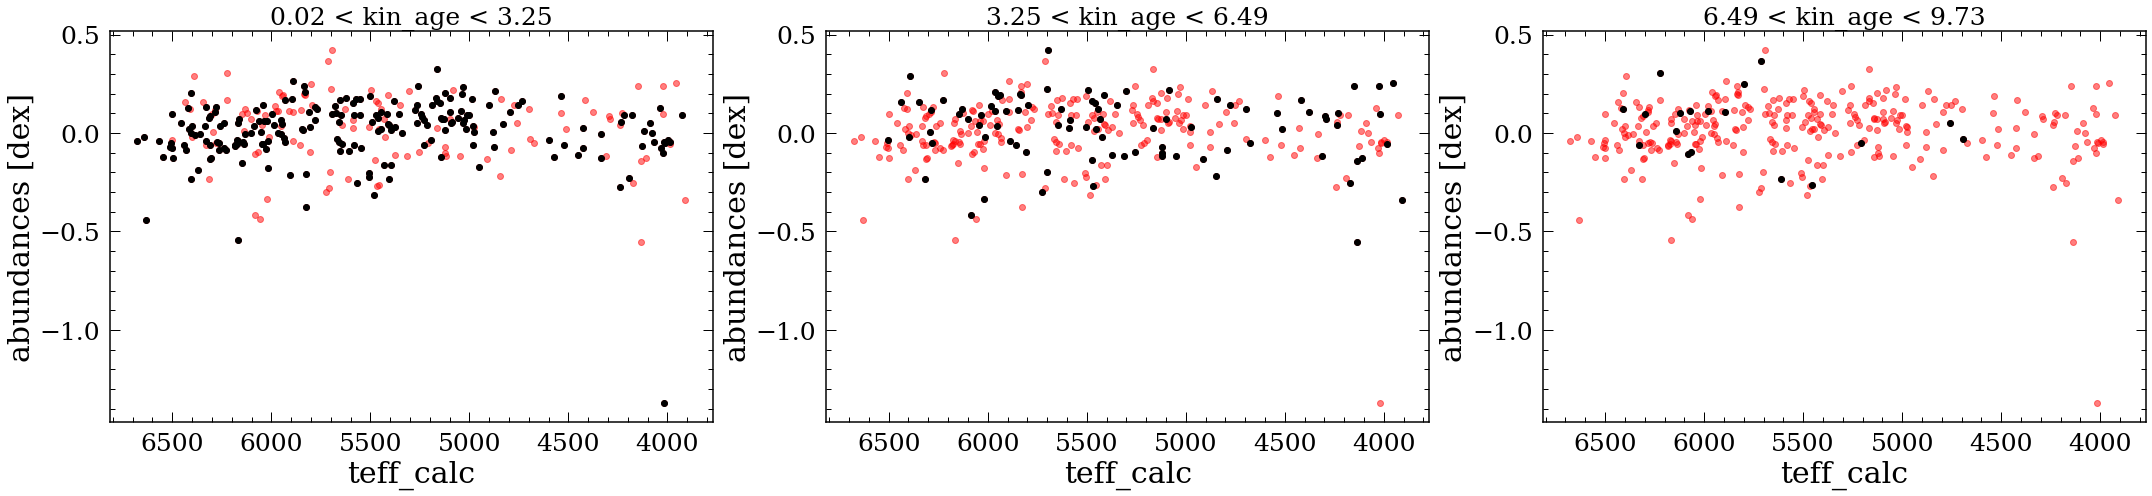

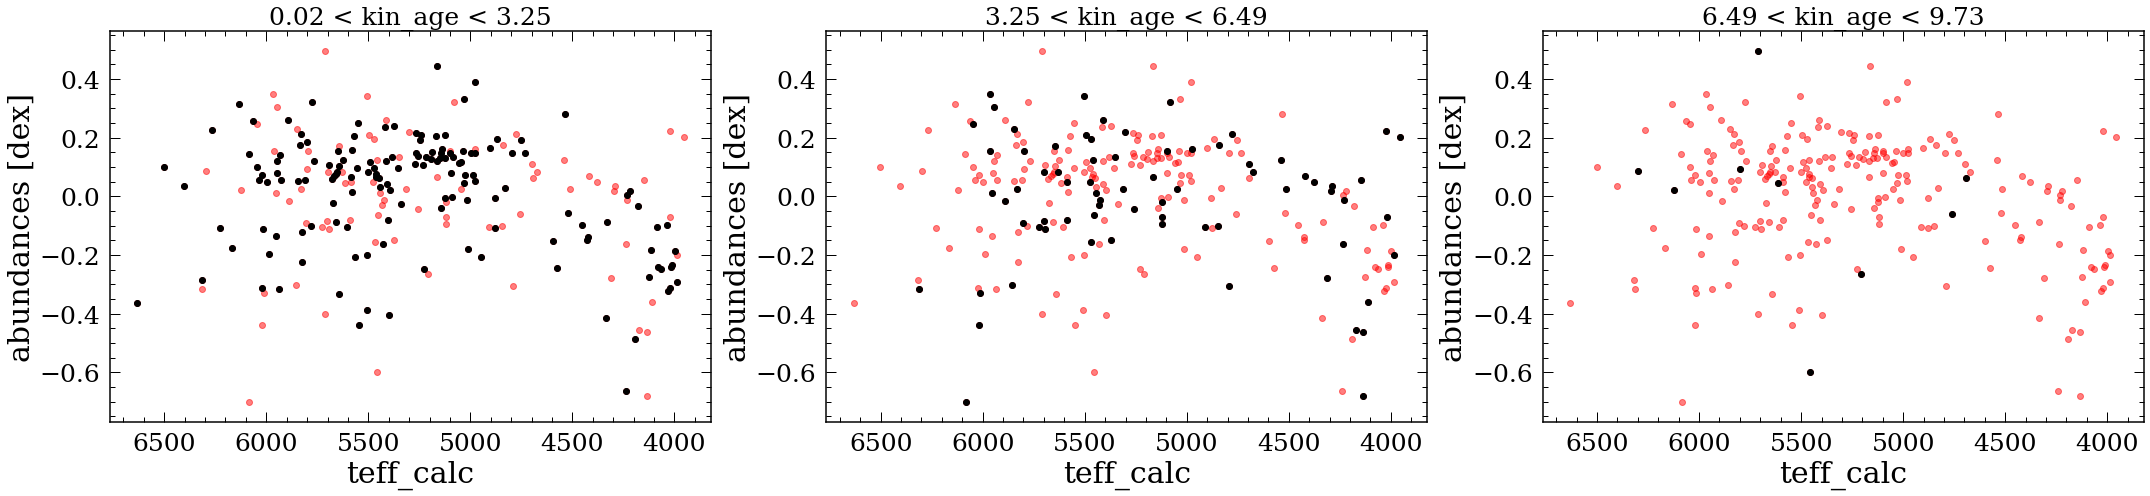

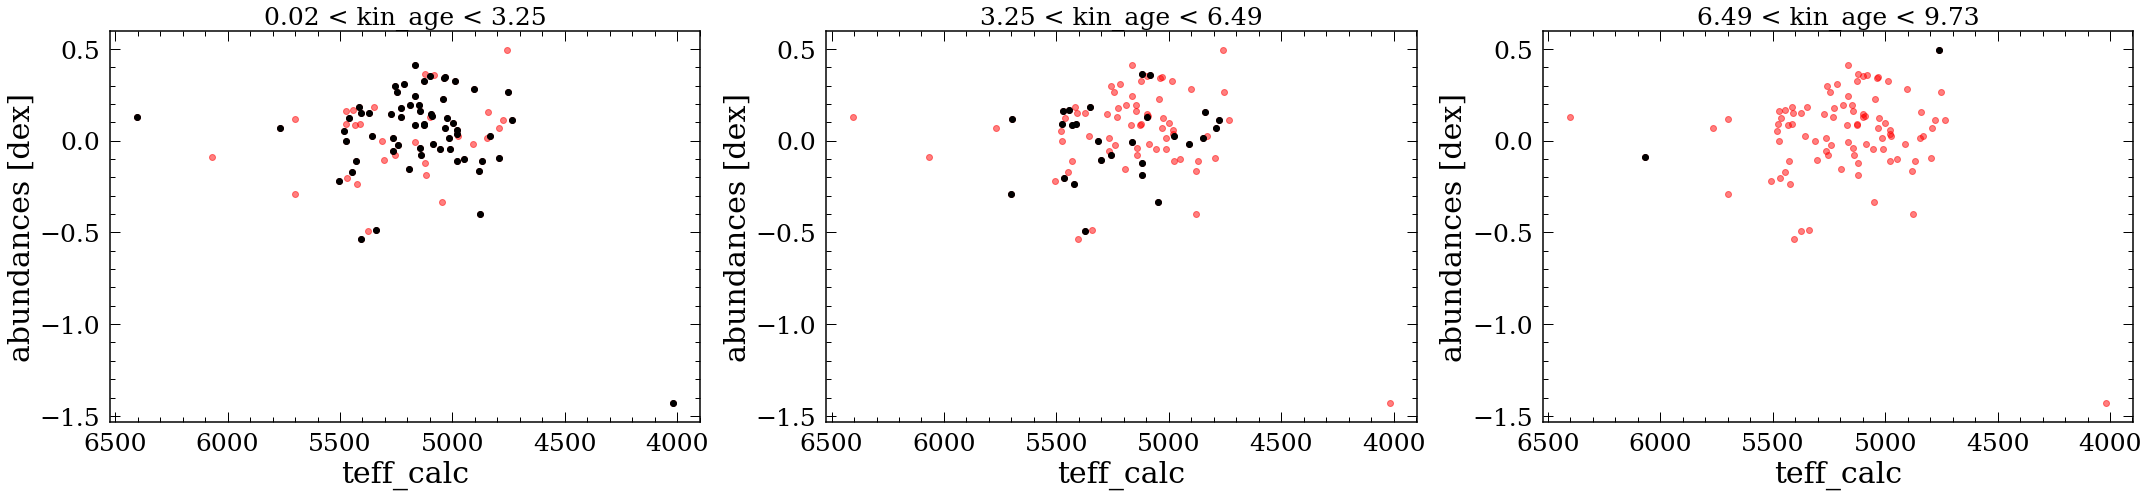

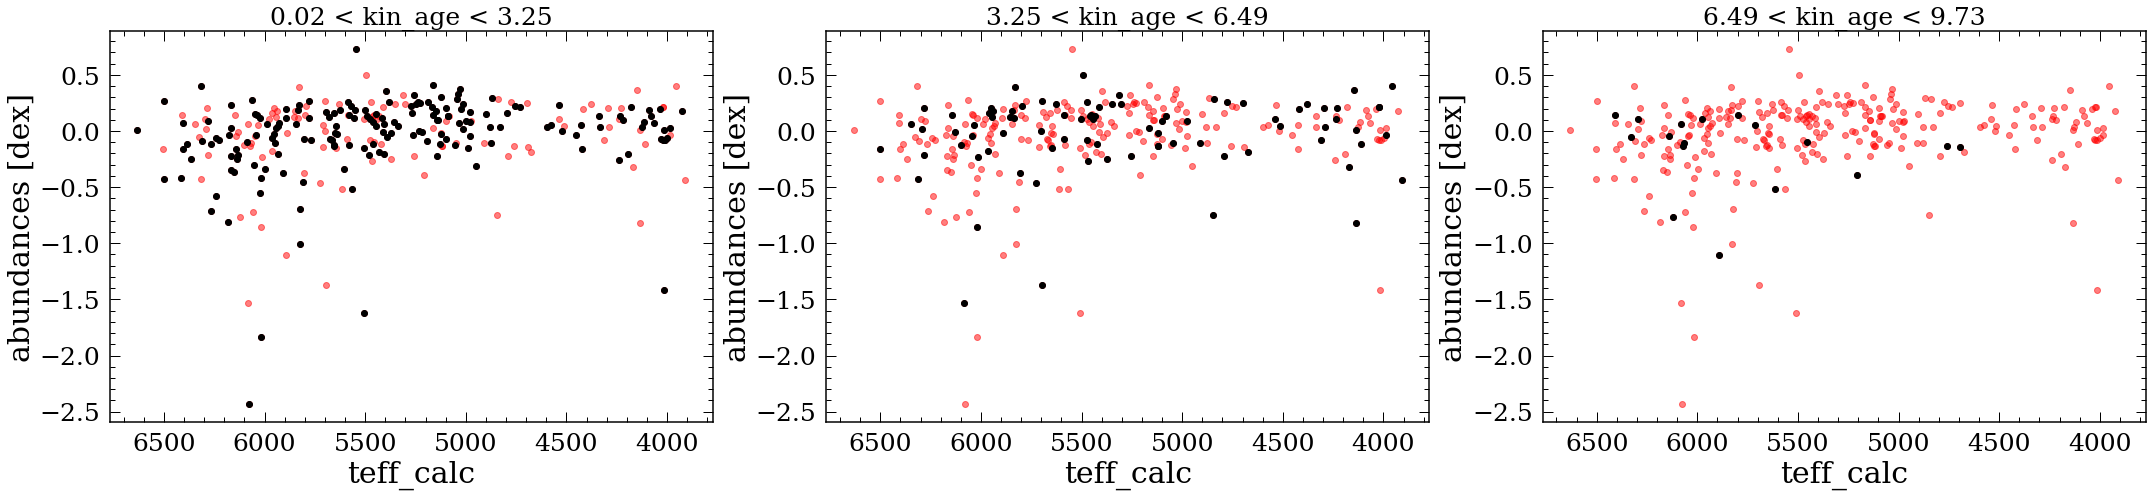

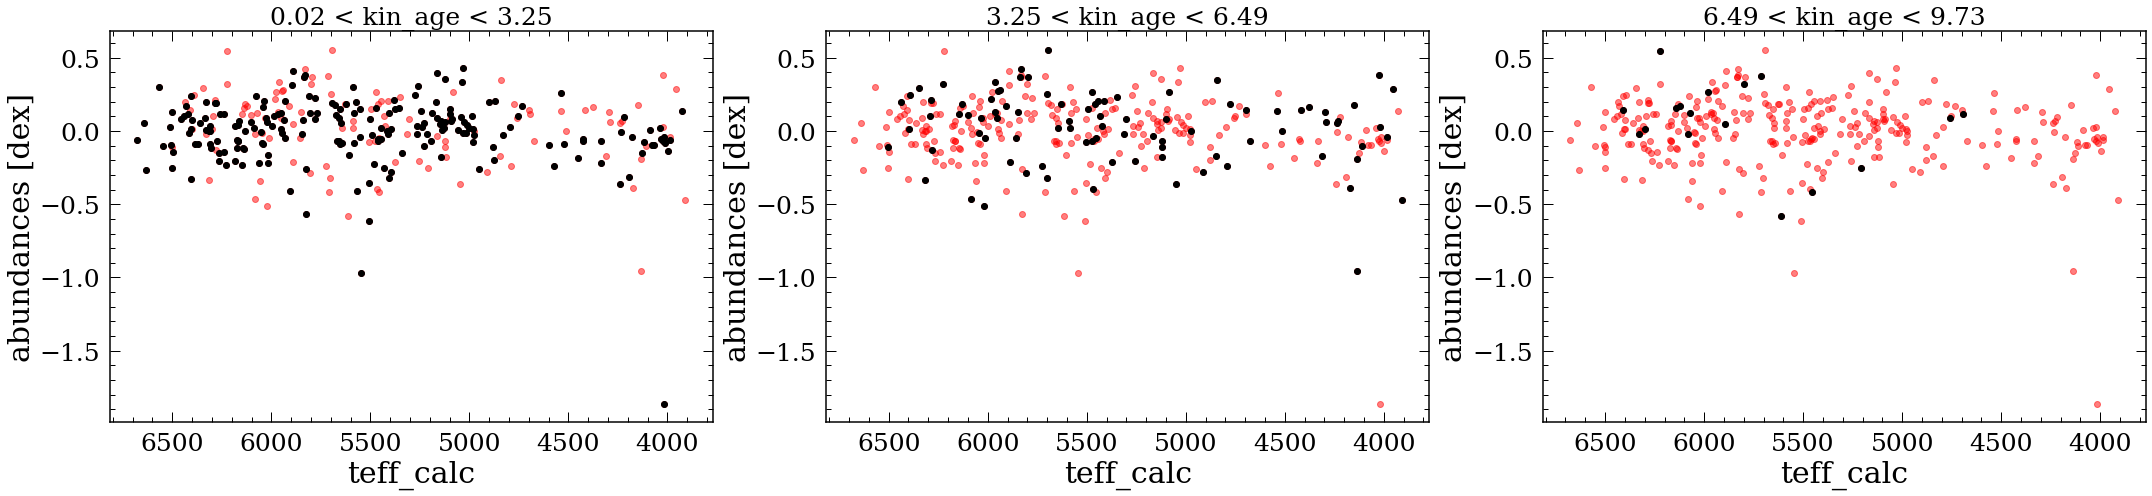

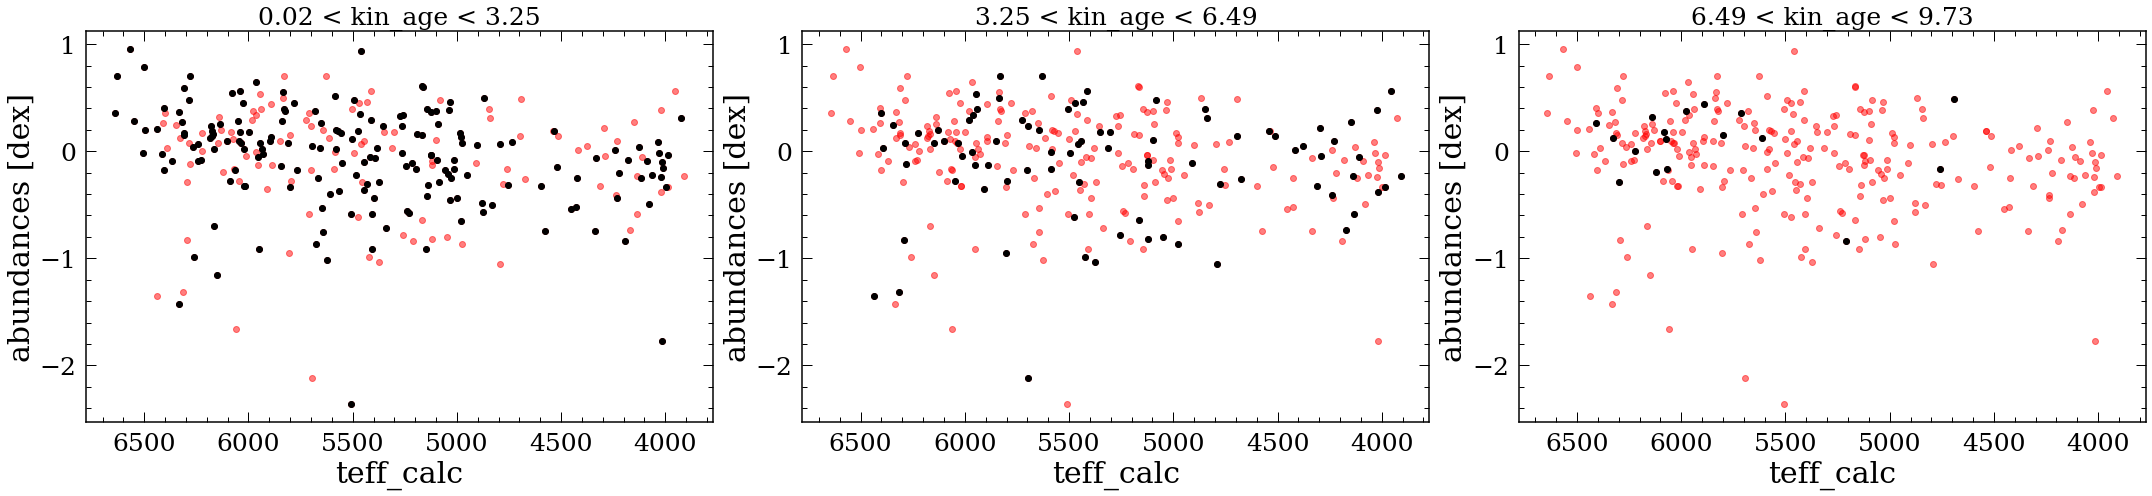

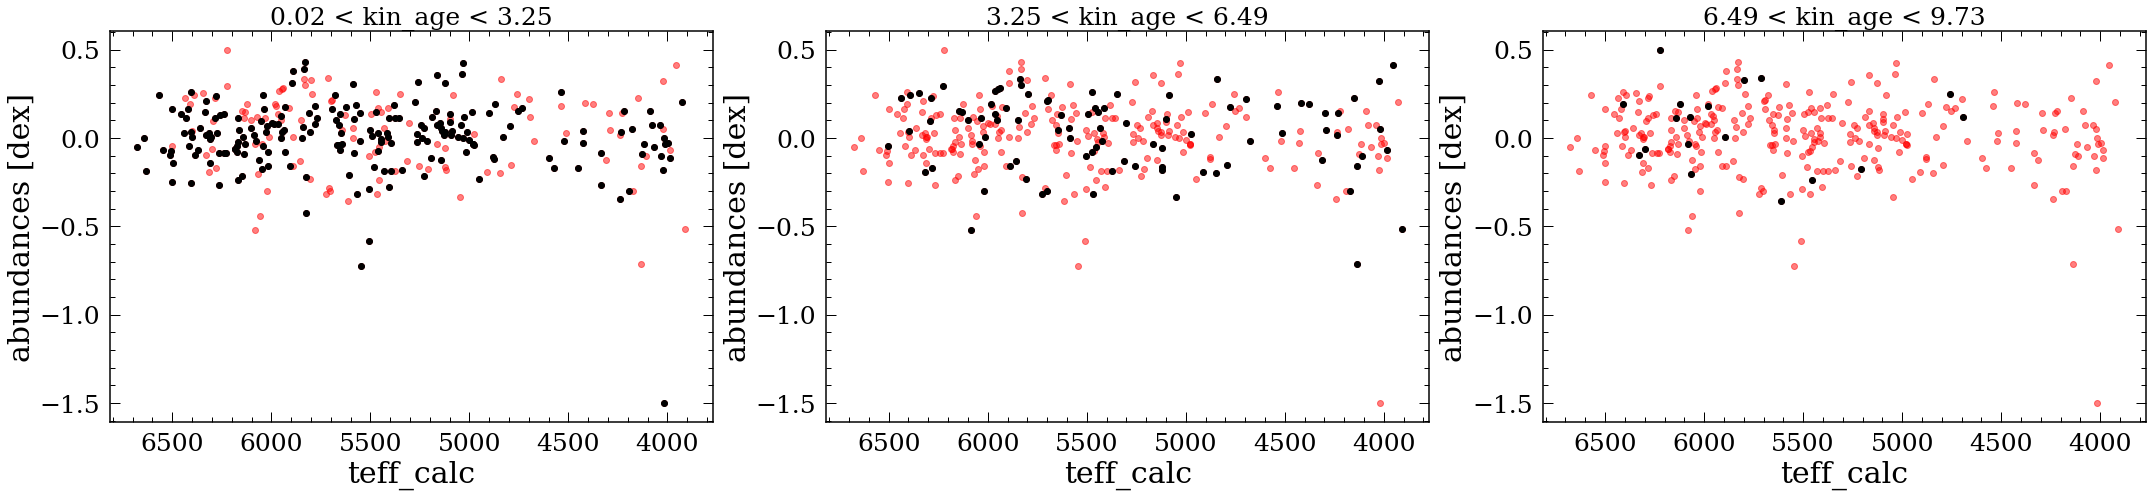

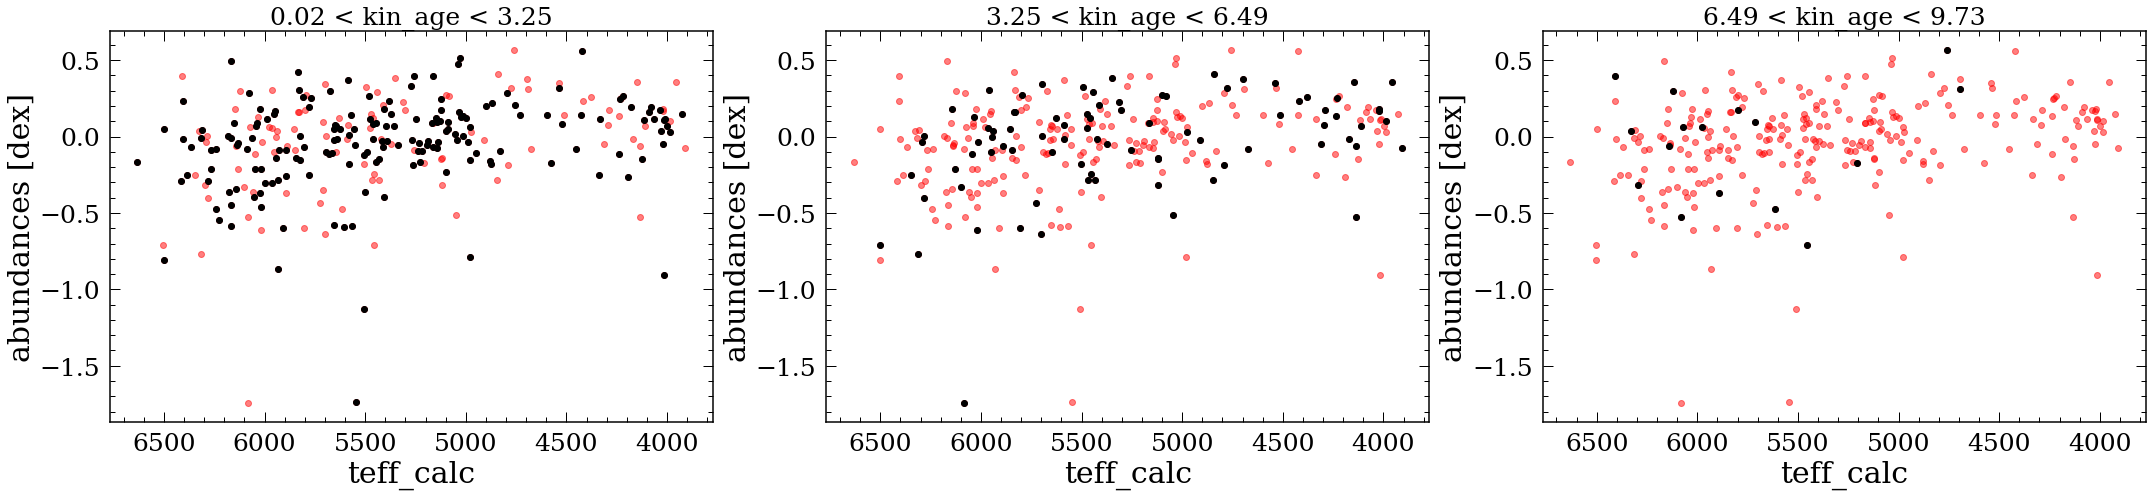

In [33]:
bins=3.
binsize=(max(df_bin_MS['kin_age'])-min(df_bin_MS['kin_age']))/bins

cm = plt.cm.get_cmap('viridis',3)
for bunds in abund:
    if bunds in df_bin_MS.columns:
        df_plt=df_bin_MS.loc[abs(df_bin_MS[bunds])<100]
        if len(df_plt)>10:
            df_plt[bunds]=df_plt[bunds]+df_plt['FE_H']
            plt.figure(figsize=(10*int(bins),7))
            for i in range(int(bins)):
                plt.subplot(1,int(bins),i+1)
                plt.scatter(df_plt['color_teffs'],df_plt[bunds],c='r',edgecolors=None,alpha=0.5)
                mask=(df_plt['kin_age']>min(df_bin_MS['kin_age'])+(i)*binsize) & (df_plt['kin_age']<min(df_bin_MS['kin_age'])+(i+1)*binsize)
                if sum(mask)==0:
                    continue
                else:
                    df_plt_logg=df_plt.loc[mask].sort_values(by=['color_teffs'])
                    plt.plot(df_plt_logg['color_teffs'],df_plt_logg[bunds],'ko')
                    """
                    plt.plot(df_plt_logg['LOGG'].rolling(10).median(),
                             df_plt_logg[bunds].rolling(10).median(),'--',linewidth=3)
                    """
                    plt.xlabel('teff_calc')
                    plt.ylabel('abundances [dex]')

                    plt.gca().invert_xaxis()
                    plt.title('%.2f < kin_age < %.2f'%(min(df_bin_MS['kin_age'])+(i)*
                                                       binsize,min(df_bin_MS['kin_age'])+
                                                       (i+1)*binsize),fontsize=25)
            plt.tight_layout()
   